# Analyze Metrics and Conduct Inference.ipynb

In [671]:
import pandas as pd
from statsmodels.stats.contingency_tables import mcnemar 
import matplotlib.pyplot as plt
import seaborn as sns
#import scipy.stats as stats


In [672]:
# Load Combined_Data.xlsx
combined_data = pd.read_excel('Combined_Data.xlsx')

# GSM8k data - limit to task = "gsm8k"
gsm8k_data = combined_data[combined_data['task'] == 'gsm8k']

# Creative writing data - limit to task = "cw"
cw_data = combined_data[combined_data['task'] == 'cw']


## Accuracy/Quality

In [673]:
# Produce table - one column for each method, one row for each model by task type
# Average values of correct_or_incorrect and creative_writing_score
# Also get variance

# Column for combined accuracy_quality - correct_or_incorrect if task = "gsm8k", creative_writing_score if task = "cw"
combined_data['accuracy_quality'] = combined_data.apply(lambda row: row['correct'] if row['task'] == 'gsm8k' else row['coherence_1_incoherent_10_very_coherent'], axis=1)

# Average accuracy_quality by model, method, task
# Also get variance
avg_accuracy_quality_with_variance = combined_data[['model', 'method', 'task', 'accuracy_quality']].groupby(['model', 'method', 'task']).agg(['mean', 'var'])['accuracy_quality'].reset_index()

# Combine mean and variance into one column that is a string with the mean and then the variance in parentheses
avg_accuracy_quality_with_variance['accuracy_quality'] = avg_accuracy_quality_with_variance.apply(lambda row: str(round(row['mean'], 2)) + ' (' + str(round(row['var'], 2)) + ')', axis=1)

avg_accuracy_quality_with_variance


,model,method,task,mean,var,accuracy_quality
0,gpt4,ape_zero_shot_cot,cw,5.46,6.210505,5.46 (6.21)
1,gpt4,ape_zero_shot_cot,gsm8k,0.93,0.065758,0.93 (0.07)
2,gpt4,direct_prompting,cw,5.71,7.298889,5.71 (7.3)
3,gpt4,direct_prompting,gsm8k,0.73,0.199091,0.73 (0.2)
4,gpt4,least_to_most,cw,5.54,5.907475,5.54 (5.91)
5,gpt4,least_to_most,gsm8k,0.95,0.047980,0.95 (0.05)
6,gpt4,manual_cot,cw,6.33,5.193030,6.33 (5.19)
7,gpt4,manual_cot,gsm8k,0.93,0.065758,0.93 (0.07)
8,gpt4,manual_few_shot,cw,6.11,6.220101,6.11 (6.22)
9,gpt4,manual_few_shot,gsm8k,0.49,0.252424,0.49 (0.25)


In [674]:
# Loop over cases where task = "cw" and output histograms of accuracy quality by model and method
# Loop over models
for model in cw_data['model'].unique():
    # Loop over methods
    for method in cw_data['method'].unique():
        # Get data for this model and method
        data = cw_data[(cw_data['model'] == model) & (cw_data['method'] == method)]
        # Plot histogram
        plt.hist(data['coherence_1_incoherent_10_very_coherent'], bins = 10)
        # Ticks for values of 1, 2, ... 10
        plt.xticks(range(1, 11))
        plt.title(model + ' - ' + method)
        plt.xlabel('Accuracy Quality')
        plt.ylabel('Count')
        # Save histogram
        plt.savefig('../Output/cw_acc_qual_' + model + '_' + method + '.png')
        plt.close()


In [675]:
# Pivot table - column method should go wide
avg_accuracy_quality_pivot = avg_accuracy_quality_with_variance.drop(columns=['mean', 'var']).set_index(['model', 'task', 'method']).unstack()
#pivot_table(index=['model', 'task'], columns='method', values='accuracy_quality').reset_index()

# Fix axis
avg_accuracy_quality_pivot = avg_accuracy_quality_pivot.rename_axis([None, None], axis=1).reset_index()

# Sort rows by task - gsm8k task first, then cw
# Sort by model - text-davinci-003 first, then gpt4
avg_accuracy_quality_pivot = avg_accuracy_quality_pivot.sort_values(by=['task', 'model'], ascending=[True, True]).reset_index().drop(columns=['index'])

print(avg_accuracy_quality_pivot.columns)

flattened_cols = [''.join(col).strip().replace('accuracy_quality', '') for col in avg_accuracy_quality_pivot.columns.values]
avg_accuracy_quality_pivot.columns = flattened_cols

print(avg_accuracy_quality_pivot)

# Order columns: direct_prompting, zero_shot_cot, ape_zero_shot_cot, tree_of_thought, self_refine, least_to_most, manual_few_shot, manual_cot
avg_accuracy_quality_pivot = avg_accuracy_quality_pivot[['model', 'task', 'direct_prompting', 'zero_shot_cot', 'ape_zero_shot_cot', 'tree_of_thought', 'self_refine', 'least_to_most', 'manual_few_shot', 'manual_cot']]

# Output to LaTeX
avg_accuracy_quality_pivot.to_latex('../Output/avg_accuracy_quality_pivot.tex', index=False)


MultiIndex([(           'model',                  ''),
            (            'task',                  ''),
            ('accuracy_quality', 'ape_zero_shot_cot'),
            ('accuracy_quality',  'direct_prompting'),
            ('accuracy_quality',     'least_to_most'),
            ('accuracy_quality',        'manual_cot'),
            ('accuracy_quality',   'manual_few_shot'),
            ('accuracy_quality',       'self_refine'),
            ('accuracy_quality',   'tree_of_thought'),
            ('accuracy_quality',     'zero_shot_cot')],
           )
  model   task ape_zero_shot_cot direct_prompting least_to_most   manual_cot  \
0  gpt4     cw       5.46 (6.21)       5.71 (7.3)   5.54 (5.91)  6.33 (5.19)   
1   td3     cw        3.9 (5.36)      4.46 (7.79)   4.45 (5.28)  4.14 (4.89)   
2  gpt4  gsm8k       0.93 (0.07)       0.73 (0.2)   0.95 (0.05)  0.93 (0.07)   
3   td3  gsm8k       0.49 (0.25)      0.23 (0.18)   0.67 (0.95)   0.6 (0.24)   

  manual_few_shot  self_refine tree

C:\Users\ijyli\AppData\Local\Temp\ipykernel_23760\280831353.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  avg_accuracy_quality_pivot = avg_accuracy_quality_pivot.sort_values(by=['task', 'model'], ascending=[True, True]).reset_index().drop(columns=['index'])


In [676]:
# Perform McNemar's Test on GSM8k data

# Get in terms of number of questions answered correctly: sum accuracy_quality column by model, method, task
gsm8k_num_correct= gsm8k_data[['model', 'method', 'task', 'correct']].groupby(['model', 'method', 'task']).sum()['correct'].reset_index()
# Rename column to num_correct
gsm8k_num_correct = gsm8k_num_correct.rename(columns={'correct': 'num_correct'})

# Make another table with counts of questions missed (number of observations minus accuracy_quality sum) by model, method, task
gsm8k_num_obs = gsm8k_data[['model', 'method', 'task', 'correct']].groupby(['model', 'method', 'task']).count()['correct'].reset_index()
# Rename column to num_obs
gsm8k_num_obs = gsm8k_num_obs.rename(columns={'correct': 'num_obs'})
# Join together by model, method, task
gsm8k_correct_incorrect_obs = gsm8k_num_correct.merge(gsm8k_num_obs, on=['model', 'method', 'task'], how='left')
# Table should have model, method, task, num_correct, num_incorrect, num_obs
gsm8k_correct_incorrect_obs['num_incorrect'] = gsm8k_correct_incorrect_obs['num_obs'] - gsm8k_correct_incorrect_obs['num_correct']

gsm8k_correct_incorrect_obs


,model,method,task,num_correct,num_obs,num_incorrect
0,gpt4,ape_zero_shot_cot,gsm8k,93.0,100,7.0
1,gpt4,direct_prompting,gsm8k,73.0,100,27.0
2,gpt4,least_to_most,gsm8k,95.0,100,5.0
3,gpt4,manual_cot,gsm8k,93.0,100,7.0
4,gpt4,manual_few_shot,gsm8k,49.0,100,51.0
5,gpt4,self_refine,gsm8k,89.0,100,11.0
6,gpt4,tree_of_thought,gsm8k,40.0,100,60.0
7,gpt4,zero_shot_cot,gsm8k,95.0,100,5.0
8,td3,ape_zero_shot_cot,gsm8k,49.0,100,51.0
9,td3,direct_prompting,gsm8k,23.0,100,77.0


### Testing Accuracy

In [677]:
# Function to perform McNemar's test
# Accepts argument of name of model, method, task

def perform_mcnemar(model, method, task):
    
    # Get direct prompting data
    dp_data = gsm8k_data[(combined_data['model'] == model) & (combined_data['method'] == 'direct_prompting') & (combined_data['task'] == task)][['conversation_number', 'correct']]
    # Rename correct to dp_correct
    dp_data = dp_data.rename(columns={'correct': 'dp_correct'})

    # Get method data
    method_data = gsm8k_data[(combined_data['model'] == model) & (combined_data['method'] == method) & (combined_data['task'] == task)][['conversation_number', 'correct']]
    # Rename correct to method_correct
    method_data = method_data.rename(columns={'correct': 'method_correct'})

    # Join together by conversation_number
    joined_data = dp_data.merge(method_data, on='conversation_number', how='left')

    # Fill contingency table cells
    dp_correct_method_correct = joined_data[(joined_data['dp_correct'] == True) & (joined_data['method_correct'] == True)].shape[0]
    dp_correct_method_incorrect = joined_data[(joined_data['dp_correct'] == True) & (joined_data['method_correct'] == False)].shape[0]
    dp_incorrect_method_correct = joined_data[(joined_data['dp_correct'] == False) & (joined_data['method_correct'] == True)].shape[0]
    dp_incorrect_method_incorrect = joined_data[(joined_data['dp_correct'] == False) & (joined_data['method_correct'] == False)].shape[0]
    
    # Create a dataset
    # Rows for dp correct and incorrect
    # Columns for method correct and incorrect
    data = [[dp_correct_method_correct, dp_correct_method_incorrect], 
            [dp_incorrect_method_correct, dp_incorrect_method_incorrect]]

#     # Create variables for data of interest
#     # direct_prompting_correct
#     print(gsm8k_correct_incorrect_obs)
#     print(gsm8k_correct_incorrect_obs[(gsm8k_correct_incorrect_obs['model'] == model) & (gsm8k_correct_incorrect_obs['method'] == "direct_prompting") & (gsm8k_correct_incorrect_obs['task'] == task)])
#     direct_prompting_correct = gsm8k_correct_incorrect_obs[(gsm8k_correct_incorrect_obs['model'] == model) & (gsm8k_correct_incorrect_obs['method'] == "direct_prompting") & (gsm8k_correct_incorrect_obs['task'] == task)]['num_correct'].values[0]
#     # direct_prompting_incorrect
#     direct_prompting_incorrect = gsm8k_correct_incorrect_obs[(gsm8k_correct_incorrect_obs['model'] == model) & (gsm8k_correct_incorrect_obs['method'] == "direct_prompting") & (gsm8k_correct_incorrect_obs['task'] == task)]['num_incorrect'].values[0]
#     # method_correct
#     method_correct = gsm8k_correct_incorrect_obs[(gsm8k_correct_incorrect_obs['model'] == model) & (gsm8k_correct_incorrect_obs['method'] == method) & (gsm8k_correct_incorrect_obs['task'] == task)]['num_correct'].values[0]
#     # method_incorrect
#     method_incorrect = gsm8k_correct_incorrect_obs[(gsm8k_correct_incorrect_obs['model'] == model) & (gsm8k_correct_incorrect_obs['method'] == method) & (gsm8k_correct_incorrect_obs['task'] == task)]['num_incorrect'].values[0]

#     # Create a dataset 
#     # Row for direct prompting then method
#     # Column for correct then incorrect
#     data = [[direct_prompting_correct, direct_prompting_incorrect], 
#             [method_correct, method_incorrect]] 

    
    print('McNemar\'s Test (Exact) for ' + model + ' ' + method + ' ' + task)
    print(data)

    # McNemar's Test, exact, without any continuity correction 
    print('No continuity correction')
    print(mcnemar(data, exact=True, correction=False)) 
    ncc_result = mcnemar(data, exact=True, correction=False)
    ncc_statistic = ncc_result.statistic
    ncc_p_value = ncc_result.pvalue

    #print(type(mcnemar(data, exact=True, correction=False)))
    #print(str(mcnemar(data, exact=True, correction=False)[0]) + ' ' + str(mcnemar(data, exact=True, correction=False)[1]))
    
    # McNemar's Test with the continuity correction 
    print('With continuity correction')
    print(mcnemar(data, exact=True, correction=True)) 
    cc_result = mcnemar(data, exact=True, correction=True)
    cc_statistic = cc_result.statistic
    cc_p_value = cc_result.pvalue

    # Return data
    return ncc_statistic, ncc_p_value, cc_statistic, cc_p_value


In [678]:
# Add McNemar's Test results to table
# Iterate over all combinations of model, method, task
# Except for method = "direct_prompting" and task = "cw"
# For each combination, perform McNemar's Test and add to table

# Create combos of model, method, task - all unique combinations of these three in combined_data
# Get unique values of model, method, task
models = combined_data['model'].unique()
methods = combined_data['method'].unique()
tasks = combined_data['task'].unique()
# Create list of all combinations of model, method, task
combinations = [(model, method, task) for model in models for method in methods for task in tasks]

# Add as rows to a dataframe
# Create empty dataframe
mcnemars_results = pd.DataFrame(columns=['model', 'method', 'task', 'statistic', 'pvalue', 'statistic_with_correction', 'pvalue_with_correction'])

# Iterate over combinations
for model, method, task in combinations:
    # Skip if method = "direct_prompting" or task = "cw"
    if method == 'direct_prompting' or task == 'cw':
        continue
    # Perform McNemar's Test
    statistic_without_correction, pvalue_without_correction, statistic_with_correction, pvalue_with_correction = perform_mcnemar(model, method, task)
    # Add to table
    mcnemars_results = pd.concat([mcnemars_results, pd.DataFrame([[model, method, task, statistic_without_correction, pvalue_without_correction, statistic_with_correction, pvalue_with_correction]], columns=['model', 'method', 'task', 'statistic', 'pvalue', 'statistic_with_correction', 'pvalue_with_correction'])])

mcnemars_results


C:\Users\ijyli\AppData\Local\Temp\ipykernel_23760\2606642921.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dp_data = gsm8k_data[(combined_data['model'] == model) & (combined_data['method'] == 'direct_prompting') & (combined_data['task'] == task)][['conversation_number', 'correct']]
C:\Users\ijyli\AppData\Local\Temp\ipykernel_23760\2606642921.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  method_data = gsm8k_data[(combined_data['model'] == model) & (combined_data['method'] == method) & (combined_data['task'] == task)][['conversation_number', 'correct']]
C:\Users\ijyli\AppData\Local\Temp\ipykernel_23760\2606642921.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dp_data = gsm8k_data[(combined_data['model'] == model) & (combined_data['method'] == 'direct_prompting') & (combined_data['task'] == task)][['conversation_number', 'correct']]
C:\Users\ijyli\AppData\Local\Temp\ipykernel_

McNemar's Test (Exact) for td3 zero_shot_cot gsm8k
[[13, 10], [49, 28]]
No continuity correction
pvalue      2.706279703008907e-07
statistic   10.0
With continuity correction
pvalue      2.706279703008907e-07
statistic   10.0
McNemar's Test (Exact) for td3 ape_zero_shot_cot gsm8k
[[11, 12], [38, 39]]
No continuity correction
pvalue      0.00030586400160359517
statistic   12.0
With continuity correction
pvalue      0.00030586400160359517
statistic   12.0
McNemar's Test (Exact) for td3 least_to_most gsm8k
[[15, 7], [43, 34]]
No continuity correction
pvalue      2.098677427397888e-07
statistic   7.0
With continuity correction
pvalue      2.098677427397888e-07
statistic   7.0
McNemar's Test (Exact) for td3 manual_few_shot gsm8k
[[11, 12], [7, 70]]
No continuity correction
pvalue      0.359283447265625
statistic   7.0
With continuity correction
pvalue      0.359283447265625
statistic   7.0
McNemar's Test (Exact) for td3 manual_cot gsm8k
[[16, 7], [44, 33]]
No continuity correction
pvalue   

,model,method,task,statistic,pvalue,statistic_with_correction,pvalue_with_correction
0,td3,zero_shot_cot,gsm8k,10.0,2.706280e-07,10.0,2.706280e-07
0,td3,ape_zero_shot_cot,gsm8k,12.0,3.058640e-04,12.0,3.058640e-04
0,td3,least_to_most,gsm8k,7.0,2.098677e-07,7.0,2.098677e-07
0,td3,manual_few_shot,gsm8k,7.0,3.592834e-01,7.0,3.592834e-01
0,td3,manual_cot,gsm8k,7.0,1.211526e-07,7.0,1.211526e-07
0,td3,tree_of_thought,gsm8k,13.0,1.000000e+00,13.0,1.000000e+00
0,td3,self_refine,gsm8k,4.0,5.488281e-01,4.0,5.488281e-01
0,gpt4,zero_shot_cot,gsm8k,1.0,2.980232e-06,1.0,2.980232e-06
0,gpt4,ape_zero_shot_cot,gsm8k,1.0,1.096725e-05,1.0,1.096725e-05
0,gpt4,least_to_most,gsm8k,0.0,4.768372e-07,0.0,4.768372e-07


In [679]:
# Rows that are significant at p < 0.05
mcnemars_results[mcnemars_results['pvalue'] < 0.05]


,model,method,task,statistic,pvalue,statistic_with_correction,pvalue_with_correction
0,td3,zero_shot_cot,gsm8k,10.0,2.706280e-07,10.0,2.706280e-07
0,td3,ape_zero_shot_cot,gsm8k,12.0,3.058640e-04,12.0,3.058640e-04
0,td3,least_to_most,gsm8k,7.0,2.098677e-07,7.0,2.098677e-07
0,td3,manual_cot,gsm8k,7.0,1.211526e-07,7.0,1.211526e-07
0,gpt4,zero_shot_cot,gsm8k,1.0,2.980232e-06,1.0,2.980232e-06
0,gpt4,ape_zero_shot_cot,gsm8k,1.0,1.096725e-05,1.0,1.096725e-05
0,gpt4,least_to_most,gsm8k,0.0,4.768372e-07,0.0,4.768372e-07
0,gpt4,manual_few_shot,gsm8k,9.0,2.715392e-04,9.0,2.715392e-04
0,gpt4,manual_cot,gsm8k,1.0,1.096725e-05,1.0,1.096725e-05
0,gpt4,tree_of_thought,gsm8k,8.0,1.964654e-06,8.0,1.964654e-06


In [680]:
# Rows that are not significant at p < 0.05
mcnemars_results[mcnemars_results['pvalue'] >= 0.05]


,model,method,task,statistic,pvalue,statistic_with_correction,pvalue_with_correction
0,td3,manual_few_shot,gsm8k,7.0,0.359283,7.0,0.359283
0,td3,tree_of_thought,gsm8k,13.0,1.000000,13.0,1.000000
0,td3,self_refine,gsm8k,4.0,0.548828,4.0,0.548828


In [681]:
# Printing gsm8k_correct_incorrect_obs again for reference
gsm8k_correct_incorrect_obs


,model,method,task,num_correct,num_obs,num_incorrect
0,gpt4,ape_zero_shot_cot,gsm8k,93.0,100,7.0
1,gpt4,direct_prompting,gsm8k,73.0,100,27.0
2,gpt4,least_to_most,gsm8k,95.0,100,5.0
3,gpt4,manual_cot,gsm8k,93.0,100,7.0
4,gpt4,manual_few_shot,gsm8k,49.0,100,51.0
5,gpt4,self_refine,gsm8k,89.0,100,11.0
6,gpt4,tree_of_thought,gsm8k,40.0,100,60.0
7,gpt4,zero_shot_cot,gsm8k,95.0,100,5.0
8,td3,ape_zero_shot_cot,gsm8k,49.0,100,51.0
9,td3,direct_prompting,gsm8k,23.0,100,77.0


## Create table for comparing each model/task/method with the appropriate direct prompting data

In [682]:
# Split dataset
no_direct_prompting_data = combined_data[combined_data['method'] != 'direct_prompting']
direct_prompting_data = combined_data[combined_data['method'] == 'direct_prompting']

# Add prefix dp_ to columns in direct_prompting_data
direct_prompting_data = direct_prompting_data.add_prefix('dp_')

# Left join datasets on model = dp_model, task = dp_task
direct_prompting_comparison = no_direct_prompting_data.merge(direct_prompting_data, left_on=['model', 'task', 'conversation_number'], right_on=['dp_model', 'dp_task', 'dp_conversation_number'], how='left')

direct_prompting_comparison


,model_task_method,conversation_number,coherence_1_incoherent_10_very_coherent,task_constraints_followed_0_not_followed_1_followed,ease_of_review_1_easy_10_hard,correct,conversation_length,input_length,output_length,conversation_cost,...,dp_sentence_length_prompts,dp_fres_prompts,dp_num_linebreaks_provided,dp_num_sentences_provided,dp_num_step_i_provided,dp_num_1_dot_etc_provided,dp_model,dp_task,dp_method,dp_accuracy_quality
0,td3_cw_zero_shot_cot_responses,1,2.0,1.0,2.0,NaN,278,63,214,0.00556,...,10.0,94.35,NaN,NaN,NaN,NaN,td3,cw,direct_prompting,1.0
1,td3_cw_zero_shot_cot_responses,2,8.0,1.0,3.0,NaN,264,73,190,0.00528,...,11.4,86.20,NaN,NaN,NaN,NaN,td3,cw,direct_prompting,7.0
2,td3_cw_zero_shot_cot_responses,3,8.0,1.0,2.0,NaN,295,79,215,0.00590,...,12.2,74.69,NaN,NaN,NaN,NaN,td3,cw,direct_prompting,1.0
3,td3_cw_zero_shot_cot_responses,4,9.0,0.0,1.0,NaN,258,59,198,0.00516,...,9.0,69.99,NaN,NaN,NaN,NaN,td3,cw,direct_prompting,10.0
4,td3_cw_zero_shot_cot_responses,5,1.0,1.0,6.0,NaN,322,79,242,0.00644,...,12.0,74.90,NaN,NaN,NaN,NaN,td3,cw,direct_prompting,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,gpt4_gsm8k_manual_cot_responses,96,NaN,NaN,NaN,1.0,833,725,108,0.02823,...,NaN,NaN,4.0,5.0,0.0,1.0,gpt4,gsm8k,direct_prompting,1.0
2796,gpt4_gsm8k_manual_cot_responses,97,NaN,NaN,NaN,1.0,778,717,61,0.02517,...,NaN,NaN,2.0,3.0,0.0,0.0,gpt4,gsm8k,direct_prompting,0.0
2797,gpt4_gsm8k_manual_cot_responses,98,NaN,NaN,NaN,1.0,847,737,110,0.02871,...,NaN,NaN,3.0,4.0,0.0,0.0,gpt4,gsm8k,direct_prompting,0.0
2798,gpt4_gsm8k_manual_cot_responses,99,NaN,NaN,NaN,1.0,875,776,99,0.02922,...,NaN,NaN,2.0,3.0,0.0,0.0,gpt4,gsm8k,direct_prompting,1.0


In [683]:
# Save direct_prompting_comparison to Excel
direct_prompting_comparison.to_excel('direct_prompting_comparison.xlsx', index=False)


## Paired t-test for quality, means of other metrics

In [684]:
# Perform paired t-test on creative writing data and all other metrics

# Metrics to t-test: 'creative_writing_score', 'ease_of_evaluation_score', 'conversation_length', 'input_length', 'output_length', 'conversation_cost', 'gsm8k_length_vs_provided', 'length_vs_direct_prompting', 'num_linebreaks', 'num_sentences', 'num_step_i', 'num_1_dot_etc', 'sentence_length', 'fres', 'num_linebreaks_prompts', 'num_sentences_prompts', 'num_step_i_prompts', 'num_1_dot_etc_prompts', 'sentence_length_prompts', 'fres_prompts'
metrics_to_t_test = ['coherence_1_incoherent_10_very_coherent', 'ease_of_review_1_easy_10_hard', 'conversation_length', 'input_length', 'output_length', 'conversation_cost', 'gsm8k_length_vs_provided', 'length_vs_direct_prompting', 'num_linebreaks', 'num_sentences', 'num_step_i', 'num_1_dot_etc', 'sentence_length', 'fres', 'num_linebreaks_prompts', 'num_sentences_prompts', 'num_step_i_prompts', 'num_1_dot_etc_prompts', 'sentence_length_prompts', 'fres_prompts']

# Create table to hold results
# Columns of model, task, method, mean metric, mean dp_metric, statistic, pvalue
t_test_results = pd.DataFrame(columns=['model', 'task', 'method', 'metric', 'dp_mean', 'using_method_mean', 'statistic', 'pvalue'])
# Iterate over model, task, method
for model, task, method in direct_prompting_comparison[['model', 'task', 'method']].drop_duplicates().values:
    # Iterate over metrics_to_t_test
    for metric in metrics_to_t_test:
        # Get data
        # Sort by conversation_number
        data = direct_prompting_comparison[(direct_prompting_comparison['model'] == model) & (direct_prompting_comparison['task'] == task) & (direct_prompting_comparison['method'] == method)].sort_values(by=['conversation_number'])
        # direct_prompting holds the metric when using direct_prompting
        direct_prompting = data['dp_' + metric]
        # using_method holds the metric when using the method
        using_method = data[metric]
        # Perform the paired sample t-test 
        statistic, pvalue = stats.ttest_rel(direct_prompting, using_method)
        # Add to table
        t_test_results = pd.concat([t_test_results, pd.DataFrame([[model, task, method, metric, direct_prompting.mean(), using_method.mean(), statistic, pvalue]], columns=['model', 'task', 'method', 'metric', 'dp_mean', 'using_method_mean', 'statistic', 'pvalue'])])

# Significance if pvalue < 0.05
t_test_results['Significant at 95%'] = t_test_results['pvalue'].apply(lambda x: 'Yes' if x < 0.05 else 'No')

# Sort by metric, model, task, method
t_test_results = t_test_results.sort_values(by=['metric', 'model', 'task', 'method']).reset_index().drop(columns=['index'])

t_test_results


c:\Users\ijyli\anaconda3\envs\anlp\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


,model,task,method,metric,dp_mean,using_method_mean,statistic,pvalue,Significant at 95%
0,gpt4,cw,ape_zero_shot_cot,coherence_1_incoherent_10_very_coherent,5.71,5.46,0.810999,0.419311,No
1,gpt4,cw,least_to_most,coherence_1_incoherent_10_very_coherent,5.71,5.54,0.607946,0.544615,No
2,gpt4,cw,manual_cot,coherence_1_incoherent_10_very_coherent,5.71,6.33,-2.094400,0.038778,Yes
3,gpt4,cw,manual_few_shot,coherence_1_incoherent_10_very_coherent,5.71,6.11,-1.271348,0.206584,No
4,gpt4,cw,self_refine,coherence_1_incoherent_10_very_coherent,5.71,6.04,-1.062998,0.290369,No
...,...,...,...,...,...,...,...,...,...
555,td3,gsm8k,manual_cot,sentence_length_prompts,NaN,NaN,NaN,NaN,No
556,td3,gsm8k,manual_few_shot,sentence_length_prompts,NaN,NaN,NaN,NaN,No
557,td3,gsm8k,self_refine,sentence_length_prompts,NaN,NaN,NaN,NaN,No
558,td3,gsm8k,tree_of_thought,sentence_length_prompts,NaN,NaN,NaN,NaN,No


In [685]:
# Sort by metric, model, task, Significant at 95%
t_test_results = t_test_results.sort_values(by=['metric', 'model', 'task', 'Significant at 95%']).reset_index().drop(columns=['index'])

t_test_results


,model,task,method,metric,dp_mean,using_method_mean,statistic,pvalue,Significant at 95%
0,gpt4,cw,ape_zero_shot_cot,coherence_1_incoherent_10_very_coherent,5.71,5.46,0.810999,0.419311,No
1,gpt4,cw,least_to_most,coherence_1_incoherent_10_very_coherent,5.71,5.54,0.607946,0.544615,No
2,gpt4,cw,manual_few_shot,coherence_1_incoherent_10_very_coherent,5.71,6.11,-1.271348,0.206584,No
3,gpt4,cw,self_refine,coherence_1_incoherent_10_very_coherent,5.71,6.04,-1.062998,0.290369,No
4,gpt4,cw,manual_cot,coherence_1_incoherent_10_very_coherent,5.71,6.33,-2.094400,0.038778,Yes
...,...,...,...,...,...,...,...,...,...
555,td3,gsm8k,manual_cot,sentence_length_prompts,NaN,NaN,NaN,NaN,No
556,td3,gsm8k,manual_few_shot,sentence_length_prompts,NaN,NaN,NaN,NaN,No
557,td3,gsm8k,self_refine,sentence_length_prompts,NaN,NaN,NaN,NaN,No
558,td3,gsm8k,tree_of_thought,sentence_length_prompts,NaN,NaN,NaN,NaN,No


In [686]:
# Rows that are not significant at p < 0.05
t_test_results[t_test_results['pvalue'] >= 0.05]


,model,task,method,metric,dp_mean,using_method_mean,statistic,pvalue,Significant at 95%
0,gpt4,cw,ape_zero_shot_cot,coherence_1_incoherent_10_very_coherent,5.710000,5.460000,0.810999,0.419311,No
1,gpt4,cw,least_to_most,coherence_1_incoherent_10_very_coherent,5.710000,5.540000,0.607946,0.544615,No
2,gpt4,cw,manual_few_shot,coherence_1_incoherent_10_very_coherent,5.710000,6.110000,-1.271348,0.206584,No
3,gpt4,cw,self_refine,coherence_1_incoherent_10_very_coherent,5.710000,6.040000,-1.062998,0.290369,No
14,td3,cw,least_to_most,coherence_1_incoherent_10_very_coherent,4.460000,4.450000,0.030069,0.976073,No
15,td3,cw,manual_cot,coherence_1_incoherent_10_very_coherent,4.460000,4.140000,0.928556,0.355378,No
16,td3,cw,manual_few_shot,coherence_1_incoherent_10_very_coherent,4.460000,4.970000,-1.630152,0.106247,No
17,td3,cw,self_refine,coherence_1_incoherent_10_very_coherent,4.460000,4.200000,0.877447,0.382368,No
18,td3,cw,zero_shot_cot,coherence_1_incoherent_10_very_coherent,4.460000,3.860000,1.884092,0.062487,No
112,gpt4,cw,self_refine,fres,63.776700,62.369000,1.616096,0.109256,No


In [687]:
# Save t_test_results to Excel
t_test_results.to_excel('t_test_results.xlsx', index=False)


## Adding release date to accuracy quality table (optional version)

In [688]:
# Release date and gains versus direct prompting

# Load Excel file "..\Selection of Prompt Engineering Methods\Hand-Labeled Method and Implementation Considerations.xlsx"
hand_labeled_data = pd.read_excel('..\Selection of Prompt Engineering Methods\Hand-Labeled Method and Implementation Considerations.xlsx')

# Keep columns ss_publication_date, "Prompt Engineering Method"
hand_labeled_data = hand_labeled_data[['ss_publication_date', 'Prompt Engineering Method']]

# Mapping names from this data to technqiue names
# "Few-Shot Learing" -> "manual_few_shot"
# "Chain-of-Thought Prompting" -> "manual_cot"
# "Zero-Shot Chain-of_Thought" -> "zero_shot_cot"
# "Automatic Prompt Engineer" -> "ape_zero_shot_cot"
# "Self-Refine" -> "self_refine"
# "Least-to-Most Prompting" -> "least_to_most"
# "Tree-of-Thought" -> "tree_of_thought"
# Set names in hand_labeled_data to these names
hand_labeled_data['technique_name'] = hand_labeled_data['Prompt Engineering Method'].replace({'Few-Shot Learning': 'manual_few_shot', 'Chain-of-Thought Prompting': 'manual_cot', 'Zero-Shot Chain-of-Thought': 'zero_shot_cot', 'Automatic Prompt Engineer': 'ape_zero_shot_cot', 'Self-Refine': 'self_refine', 'Least-to-Most Prompting': 'least_to_most', 'Tree-of-Thought': 'tree_of_thought'})

# Keep cases where technique_name is not 'Prompt Engineering Method'
hand_labeled_data = hand_labeled_data[hand_labeled_data['technique_name'] != hand_labeled_data['Prompt Engineering Method']]

# Convert ss_publication_date to "YYYY-MM-DD"
hand_labeled_data['ss_publication_date'] = hand_labeled_data['ss_publication_date'].dt.strftime('%Y-%m-%d')

# Drop the item with technique_name = 'tree_of_thought' that has the higher ss_publication_date
# Just keep the row with min ss_publication_date for each technique_name
hand_labeled_data = hand_labeled_data.groupby(['technique_name']).min().reset_index()
print(hand_labeled_data)

# Add ss_publication_date to avg_accuracy_quality_pivot
# The value should be for each column, right below the column name
# Transpose accuracy_quality_pivot
avg_accuracy_quality_pivot_transposed = avg_accuracy_quality_pivot.transpose().reset_index()

# Set name of first column to "technique_name"
avg_accuracy_quality_pivot_transposed = avg_accuracy_quality_pivot_transposed.rename(columns={'index': 'technique_name'})

# Left join hand_labeled_data to avg_accuracy_quality_pivot_transposed on technique_name
avg_accuracy_quality_pivot_transposed = avg_accuracy_quality_pivot_transposed.merge(hand_labeled_data, on='technique_name', how='left')

# Transpose back
avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_transposed.transpose().reset_index()

# # Set names to last row
# avg_accuracy_quality_pivot_with_date.columns = avg_accuracy_quality_pivot_with_date.iloc[-1]
# # Drop first row, reset index
# avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.drop([0]).reset_index().drop(columns=['index'])
# # Drop row where technique_name is "Prompt Engineering Method"
# #avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date[avg_accuracy_quality_pivot_with_date['technique_name'] != 'Prompt Engineering Method']
# # In first column, set values of "0", "1", "2", "3" to blanks
# #avg_accuracy_quality_pivot_with_date['technique_name'] = avg_accuracy_quality_pivot_with_date['technique_name'].replace({'0': '', '1': '', '2': '', '3': ''})
# # Drop column tecnique_name
# #avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.drop(columns=['technique_name'])
# # Drop first column
# avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.iloc[:, 1:]
# # Set second column name to "Model"
# avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.rename(index={1: 'Model'})
# # Set third column name to "Task"
# avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.rename(index={2: 'Task'})
# avg_accuracy_quality_pivot_with_date.rename(columns={avg_accuracy_quality_pivot_with_date.columns[0]: 'Model'}, inplace=True)
# avg_accuracy_quality_pivot_with_date.rename(columns={avg_accuracy_quality_pivot_with_date.columns[1]: 'Task'}, inplace=True)
# Drop bottom row
#avg_accuracy_quality_pivot_with_date = avg_accuracy_quality_pivot_with_date.drop([avg_accuracy_quality_pivot_with_date.index[-1]])
# Move bottom row to top
#avg_accuracy_quality_pivot_with_date = pd.concat([avg_accuracy_quality_pivot_with_date.iloc[[-1]], avg_accuracy_quality_pivot_with_date.iloc[:-1]]).reset_index().drop(columns=['index'])
# Set column names
#new_part = ['Model', 'Task', 'Direct Prompting']
#new_names = new_part.extend(avg_accuracy_quality_pivot_with_date.columns[3:])
#avg_accuracy_quality_pivot_with_date.columns = new_names
# avg_accuracy_quality_pivot_with_date.columns = ['Model', 'Task', 'Zero-Shot Chain-of-Thought', 'Automatic Prompt Engineer', 'Tree-of-Thought',                'Self-Refine',
#           'Least-to-Most Prompting',          'Few-Shot Learning',
#        'Chain-of-Thought Prompting']
print(avg_accuracy_quality_pivot_with_date.columns)

# Output to LaTeX
print(avg_accuracy_quality_pivot_with_date)
avg_accuracy_quality_pivot_with_date.to_latex('../Output/avg_accuracy_quality_pivot_with_date.tex', index=False)


      technique_name ss_publication_date   Prompt Engineering Method
0  ape_zero_shot_cot          2022-11-03   Automatic Prompt Engineer
1      least_to_most          2022-05-21     Least-to-Most Prompting
2         manual_cot          2022-01-28  Chain-of-Thought Prompting
3    manual_few_shot          2020-05-28           Few-Shot Learning
4        self_refine          2023-03-30                 Self-Refine
5    tree_of_thought          2023-05-15             Tree-of-Thought
6      zero_shot_cot          2022-05-24  Zero-Shot Chain-of-Thought
Index(['index', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')
                       index      0      1                 2  \
0             technique_name  model   task  direct_prompting   
1                          0   gpt4     cw        5.71 (7.3)   
2                          1    td3     cw       4.46 (7.79)   
3                          2   gpt4  gsm8k        0.73 (0.2)   
4                          3    td3  gsm8k       0.23 (0.18)   
5

## Generic Function for a table of means for a metric

In [689]:
def means_table(metric):

    # Average combined_data metric by model, method, task
    avg_combined_data_metric = combined_data[['model', 'method', 'task', metric]].groupby(['model', 'method', 'task']).agg(['mean'])[metric].reset_index()

    # Pivot table - column method should go wide
    avg_combined_data_metric_pivot = avg_combined_data_metric.set_index(['model', 'task', 'method']).unstack()
    #pivot_table(index=['model', 'task'], columns='method', values='accuracy_quality').reset_index()

    # Fix axis
    avg_combined_data_metric_pivot = avg_combined_data_metric_pivot.rename_axis([None, None], axis=1).reset_index()

    # Sort rows by task - gsm8k task first, then cw
    # Sort by model - text-davinci-003 first, then gpt4
    avg_combined_data_metric_pivot = avg_combined_data_metric_pivot.sort_values(by=['task', 'model'], ascending=[True, True])

    flattened_cols = [''.join(col).strip().replace('mean', '') for col in avg_combined_data_metric_pivot.columns.values]
    avg_combined_data_metric_pivot.columns = flattened_cols

    print(avg_combined_data_metric_pivot)

    # Order columns: direct_prompting, zero_shot_cot, ape_zero_shot_cot, tree_of_thought, self_refine, least_to_most, manual_few_shot, manual_cot
    avg_combined_data_metric_pivot = avg_combined_data_metric_pivot[['model', 'task', 'direct_prompting', 'zero_shot_cot', 'ape_zero_shot_cot', 'tree_of_thought', 'self_refine', 'least_to_most', 'manual_few_shot', 'manual_cot']]

    # Output to LaTeX
    avg_combined_data_metric_pivot.to_latex('../Output/avg_' + metric + '_pivot.tex', index=False)



## Length

Run generic function for length of entire interaction, length of all prompts, financial cost

Baseline comparison ratios, change in accuracy/quality plots

In [690]:
means_table('conversation_length')
means_table('input_length')
means_table('conversation_cost')


  model   task  ape_zero_shot_cot  direct_prompting  least_to_most  \
0  gpt4     cw             470.72            337.33        1091.41   
2   td3     cw             274.04            200.41        1025.02   
1  gpt4  gsm8k             243.93            146.69         332.36   
3   td3  gsm8k             181.76             87.06         272.27   

   manual_cot  manual_few_shot  self_refine  tree_of_thought  zero_shot_cot  
0      968.75           751.04       520.06          1325.17         459.98  
2      960.51           695.41       382.19           916.81         256.53  
1      850.04           579.69       344.86           764.72         223.88  
3      722.70           533.94       125.99           248.80         166.02  
  model   task  ape_zero_shot_cot  direct_prompting  least_to_most  \
0  gpt4     cw              84.89             65.89         754.89   
2   td3     cw              73.49             52.49         736.49   
1  gpt4  gsm8k              93.50             72.

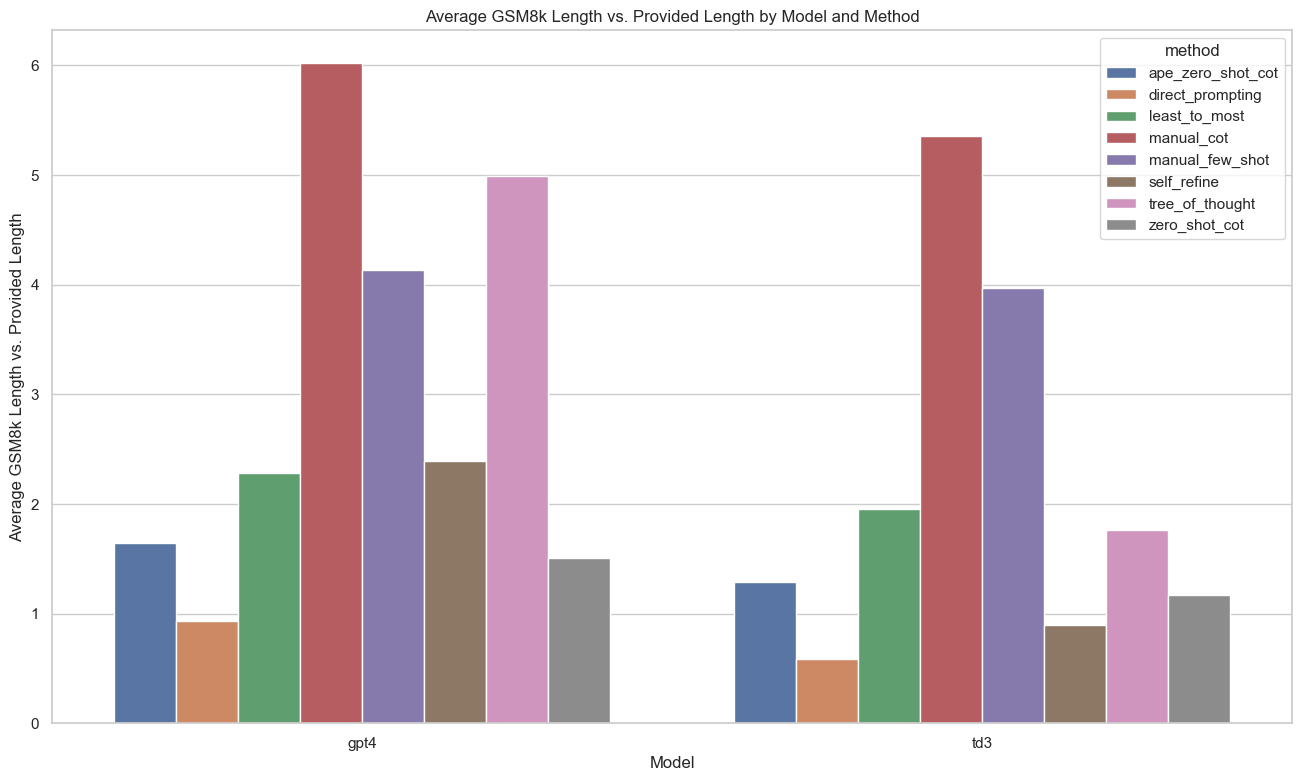

In [691]:
# Plot gsm8k_length_vs_provided in a bar chart
# Limit to gsm8k data
# Get means by model, method
gsm8k_length_vs_provided_means = gsm8k_data[['model', 'method', 'gsm8k_length_vs_provided']].groupby(['model', 'method']).agg(['mean'])['gsm8k_length_vs_provided'].reset_index()

# Bar chart by model, method
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 9))
sns.barplot(x='model', y='mean', hue='method', data=gsm8k_length_vs_provided_means)
plt.xlabel('Model')
plt.ylabel('Average GSM8k Length vs. Provided Length')
plt.title('Average GSM8k Length vs. Provided Length by Model and Method')
plt.savefig('../Output/gsm8k_length_vs_provided_means.png')
plt.show()


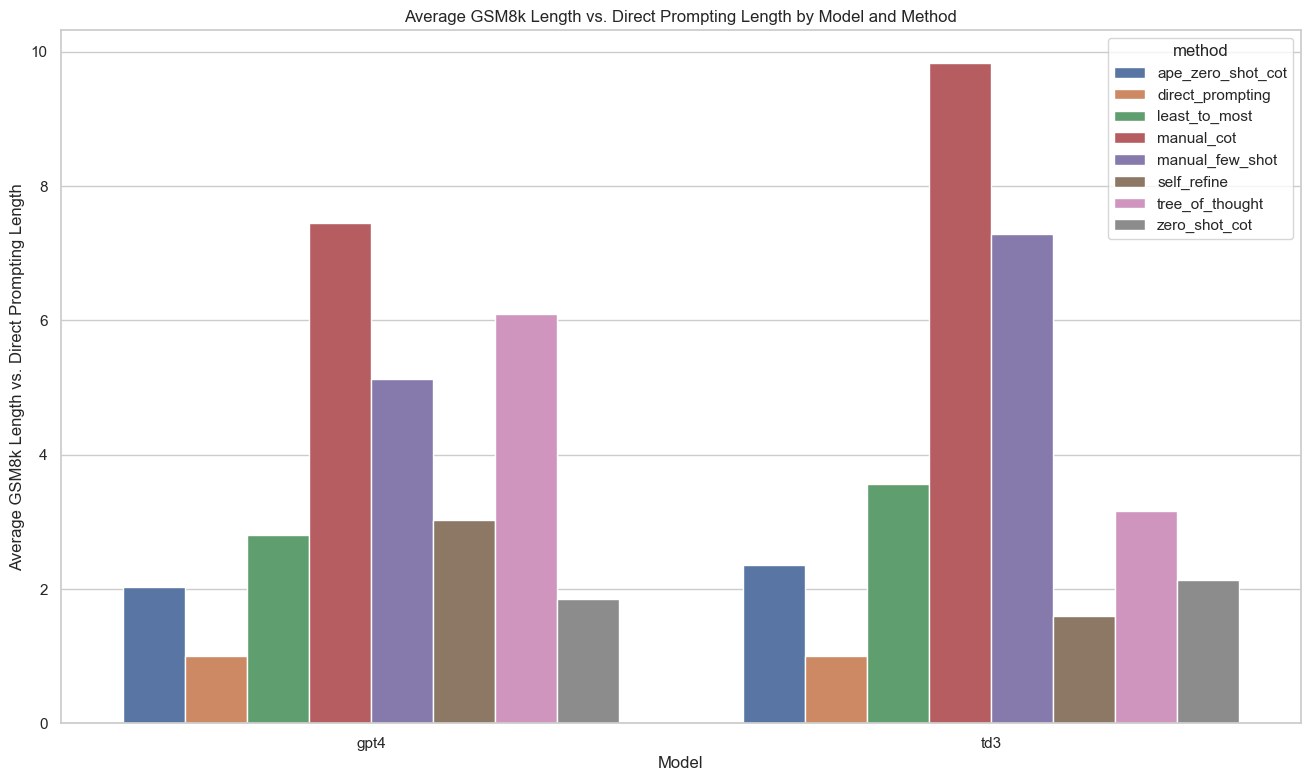

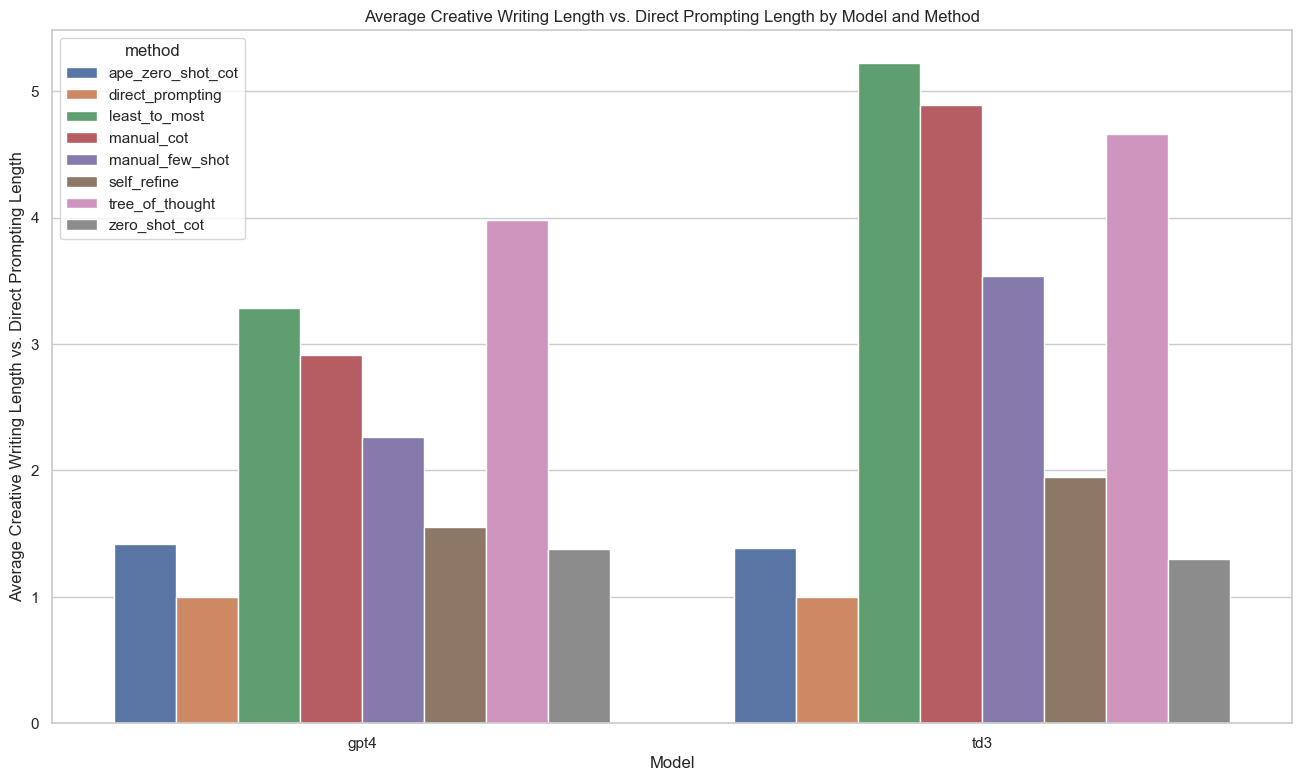

In [692]:
# Plot length_vs_direct_prompting in a bar chart
# Get means by model, method, task
length_vs_direct_prompting_means = combined_data[['model', 'method', 'task', 'length_vs_direct_prompting']].groupby(['model', 'method', 'task']).agg(['mean'])['length_vs_direct_prompting'].reset_index()

# Bar chart by model, method, task

# GSM8k plot
plt.figure(figsize=(16, 9))
sns.barplot(x='model', y='mean', hue='method', data=length_vs_direct_prompting_means[length_vs_direct_prompting_means['task'] == 'gsm8k'])
plt.xlabel('Model')
plt.ylabel('Average GSM8k Length vs. Direct Prompting Length')
plt.title('Average GSM8k Length vs. Direct Prompting Length by Model and Method')
plt.savefig('../Output/gsm8k_length_vs_direct_prompting_means.png')
plt.show()

# Creative writing plot
plt.figure(figsize=(16, 9))
sns.barplot(x='model', y='mean', hue='method', data=length_vs_direct_prompting_means[length_vs_direct_prompting_means['task'] == 'cw'])
plt.xlabel('Model')
plt.ylabel('Average Creative Writing Length vs. Direct Prompting Length')
plt.title('Average Creative Writing Length vs. Direct Prompting Length by Model and Method')
plt.savefig('../Output/cw_length_vs_direct_prompting_means.png')
plt.show()


In [693]:
# Compute change in accuracy/quality per change in length (versus direct prompting)

# In the direct_prompting_comparison table, get averages of conversation_length, dp_conversation_length, accuracy_quality, dp_accuracy_quality by model, method, task
averages_for_changes = direct_prompting_comparison[['model', 'method', 'task', 'conversation_length', 'dp_conversation_length', 'accuracy_quality', 'dp_accuracy_quality']].groupby(['model', 'method', 'task']).agg(['mean']).reset_index()

# Compute change in accuracy_quality per change in conversation_length
# accuracy_quality - dp_accuracy_quality
# divided by
# conversation_length - dp_conversation_length
averages_for_changes['change_in_accuracy_quality_per_change_in_conversation_length'] = (averages_for_changes['accuracy_quality']['mean'] - averages_for_changes['dp_accuracy_quality']['mean']) / (averages_for_changes['conversation_length']['mean'] - averages_for_changes['dp_conversation_length']['mean'])


In [694]:
# Look just at change in accuracy quality
just_change_acc_qual = averages_for_changes
just_change_acc_qual['change_in_accuracy_quality'] = (just_change_acc_qual['accuracy_quality']['mean'] - just_change_acc_qual['dp_accuracy_quality']['mean'])
# Sort by task, method, model
#just_change_acc_qual = just_change_acc_qual.sort_values(by=['task', 'method', 'model']).reset_index().drop(columns=['index'])

just_change_acc_qual = just_change_acc_qual[['model', 'method', 'task', 'change_in_accuracy_quality']]
# Unstack model column
just_change_acc_qual = just_change_acc_qual.set_index(['task', 'method', 'model']).unstack()

# Column that is gpt4 minus td3
#just_change_acc_qual['gpt4_minus_td3'] = just_change_acc_qual['gpt4'] - just_change_acc_qual['td3']

print(just_change_acc_qual)


                        change_in_accuracy_quality      
                                                        
model                                         gpt4   td3
task  method                                            
cw    ape_zero_shot_cot                      -0.25 -0.56
      least_to_most                          -0.17 -0.01
      manual_cot                              0.62 -0.32
      manual_few_shot                         0.40  0.51
      self_refine                             0.33 -0.26
      tree_of_thought                        -0.95 -1.09
      zero_shot_cot                           0.58 -0.60
gsm8k ape_zero_shot_cot                       0.20  0.26
      least_to_most                           0.22  0.44
      manual_cot                              0.20  0.37
      manual_few_shot                        -0.24 -0.05
      self_refine                             0.16 -0.03
      tree_of_thought                        -0.33  0.00
      zero_shot_cot            

In [695]:
print(averages_for_changes)


   model             method   task conversation_length dp_conversation_length  \
                                                  mean                   mean   
0   gpt4  ape_zero_shot_cot     cw              470.72                 337.33   
1   gpt4  ape_zero_shot_cot  gsm8k              243.93                 146.69   
2   gpt4      least_to_most     cw             1091.41                 337.33   
3   gpt4      least_to_most  gsm8k              332.36                 146.69   
4   gpt4         manual_cot     cw              968.75                 337.33   
5   gpt4         manual_cot  gsm8k              850.04                 146.69   
6   gpt4    manual_few_shot     cw              751.04                 337.33   
7   gpt4    manual_few_shot  gsm8k              579.69                 146.69   
8   gpt4        self_refine     cw              520.06                 337.33   
9   gpt4        self_refine  gsm8k              344.86                 146.69   
10  gpt4    tree_of_thought 

In [696]:
# Recode 'model' as 'Model' - change gpt4 to "GPT-4" and td3 to "Text-Davinci-003"
averages_for_changes['Model'] = averages_for_changes['model'].replace({'gpt4': 'GPT-4', 'td3': 'Text-Davinci-003'})
# Recode 'method' as 'Method' - change ape_zero_shot_cot to "APE Zero-Shot COT", zero_shot_cot to "Zero-Shot COT", least_to_most to "Least-to-Most", manual_cot to "Manual COT", manual_few_shot to "Manual Few-Shot", self_refine to "Self-Refine", tree_of_thought to "Tree-of-Thought"
averages_for_changes['Method'] = averages_for_changes['method'].replace({'ape_zero_shot_cot': 'APE Zero-Shot COT', 'zero_shot_cot': 'Zero-Shot COT', 'least_to_most': 'Least-to-Most', 'manual_cot': 'Manual COT', 'manual_few_shot': 'Manual Few-Shot', 'self_refine': 'Self-Refine', 'tree_of_thought': 'Tree-of-Thought'})


In [697]:
# Create transformed version for gsm8k - multiply change in accuracy_quality per change in conversation_length by 100 to get percentage points improvement per token
averages_for_changes_gsm8k = averages_for_changes[averages_for_changes['task'] == 'gsm8k']
averages_for_changes_gsm8k['Percentage Points Accuracy Improvement Per Additional Token'] = averages_for_changes_gsm8k['change_in_accuracy_quality_per_change_in_conversation_length'] * 100



C:\Users\ijyli\AppData\Local\Temp\ipykernel_23760\1737752169.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  averages_for_changes_gsm8k['Percentage Points Accuracy Improvement Per Additional Token'] = averages_for_changes_gsm8k['change_in_accuracy_quality_per_change_in_conversation_length'] * 100


In [698]:
# Create transformed version for cw - multiply change in accuracy_quality per change in conversation length by 1000 to get cw score improvement per 1000 tokens
averages_for_changes_cw = averages_for_changes[averages_for_changes['task'] == 'cw']
averages_for_changes_cw['Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens'] = averages_for_changes_cw['change_in_accuracy_quality_per_change_in_conversation_length'] * 1000



C:\Users\ijyli\AppData\Local\Temp\ipykernel_23760\3580115725.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  averages_for_changes_cw['Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens'] = averages_for_changes_cw['change_in_accuracy_quality_per_change_in_conversation_length'] * 1000


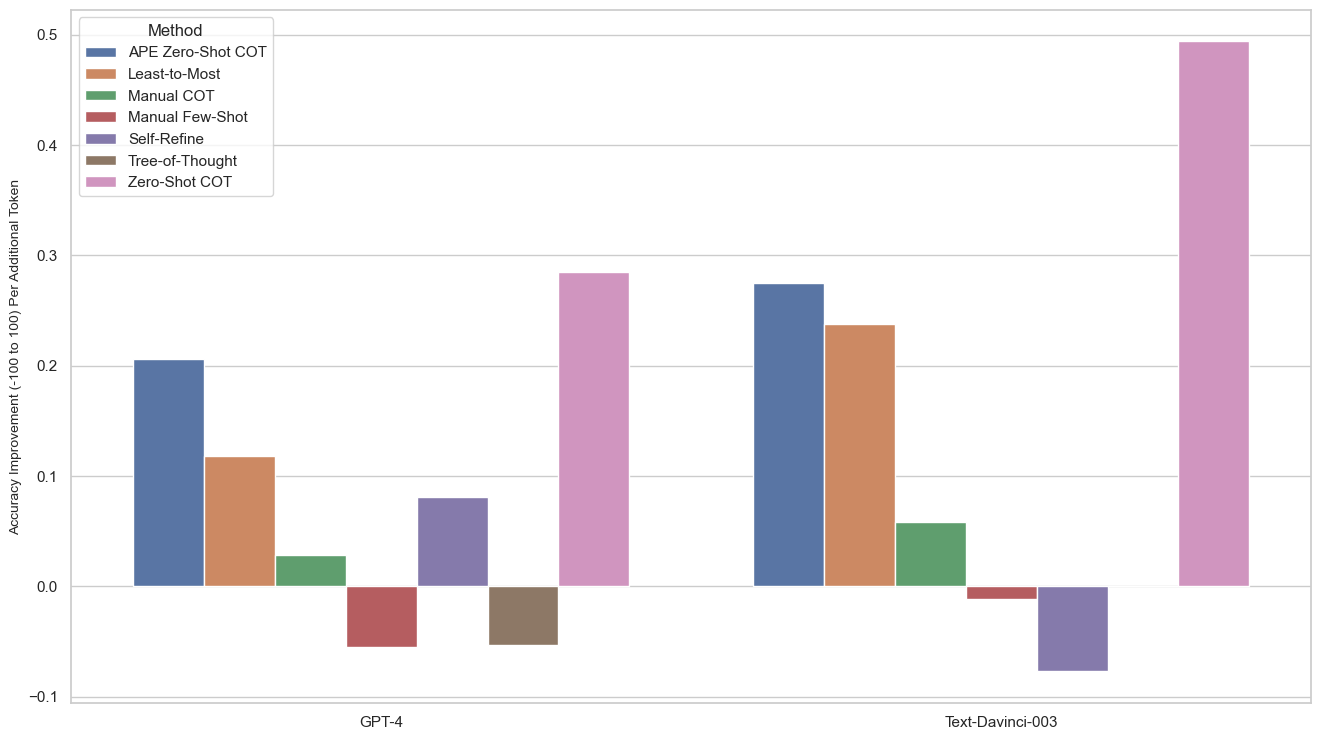

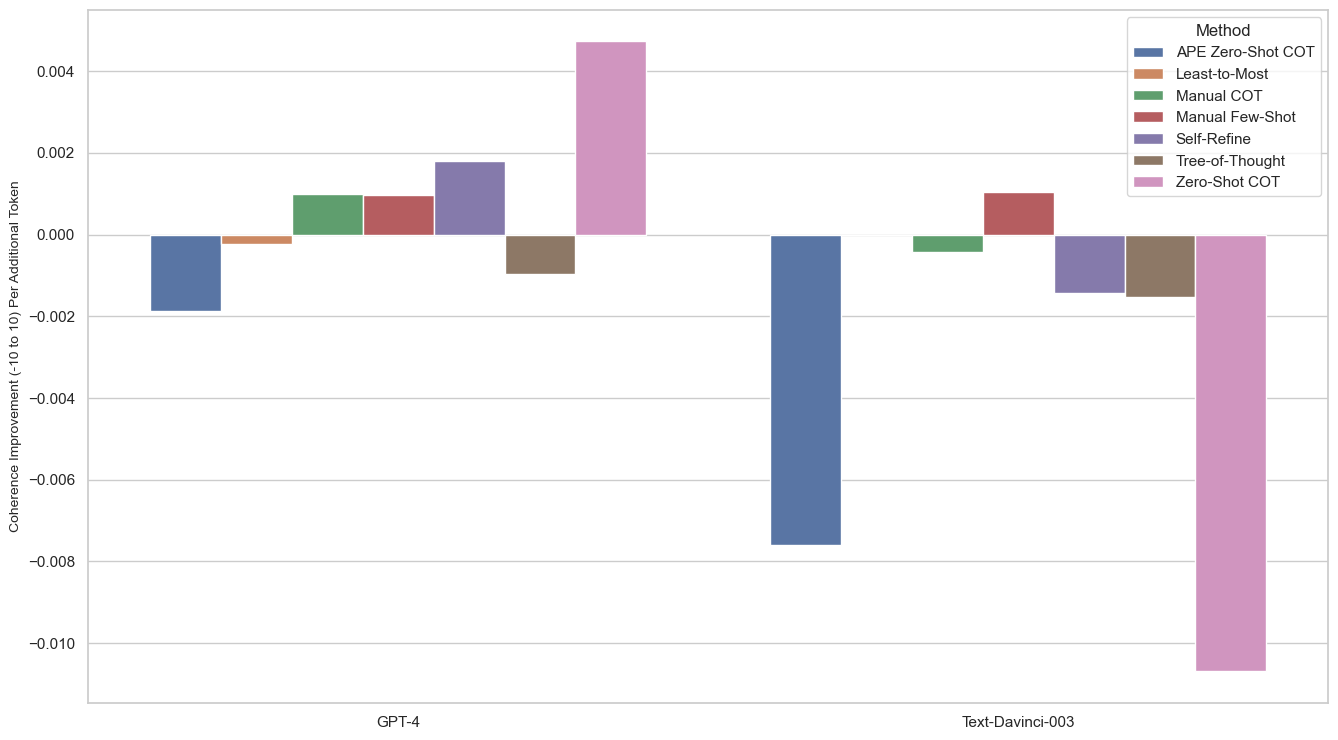

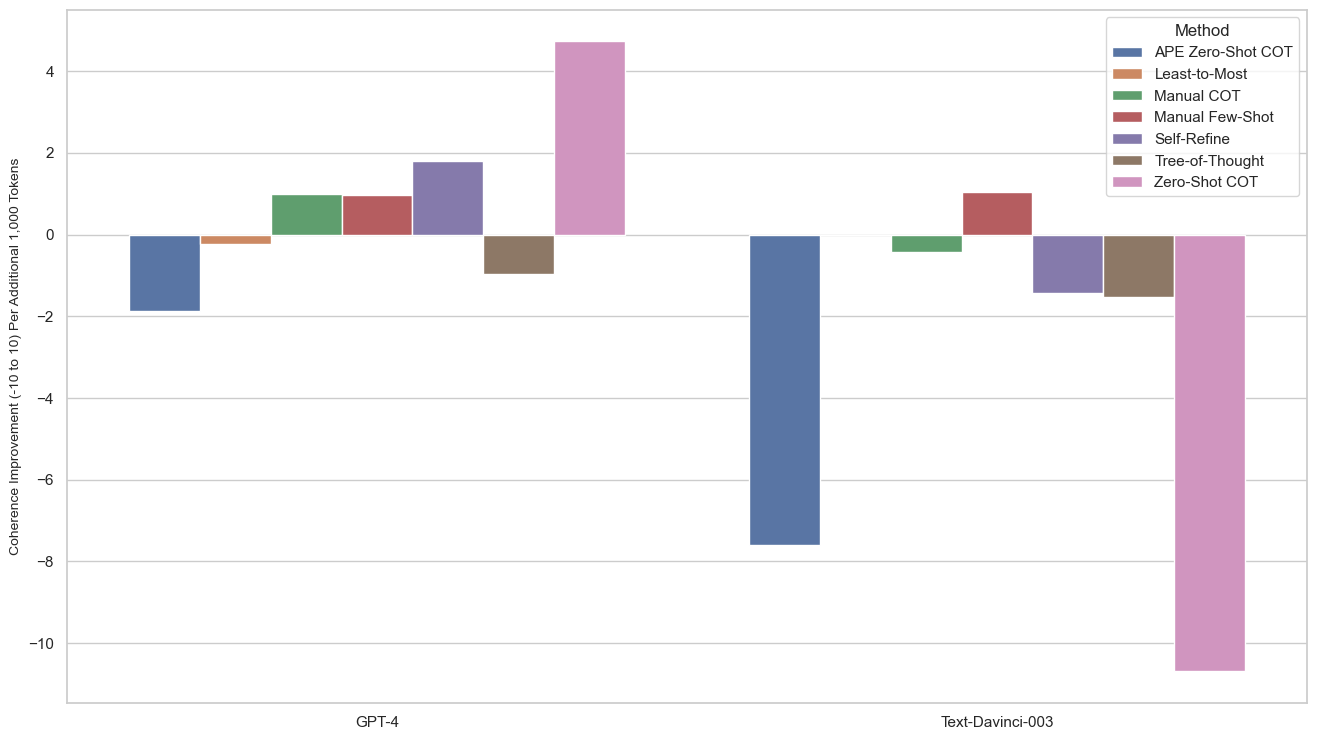

In [699]:
# Plot change in accuracy_quality per change in conversation_length
# Bar chart by model, method, task
# GSM8k plot
plt.figure(figsize=(16, 9))
sns.barplot(x='Model', y='Percentage Points Accuracy Improvement Per Additional Token', hue='Method', data=averages_for_changes_gsm8k)
#plt.xlabel('Model')
#plt.xlabel('')
#plt.ylabel('Change in GSM8K Accuracy per Change in Conversation Length')
# No x axis title
plt.gca().set_xlabel('')
# Reduce y axis title font size
plt.gca().set_ylabel('Accuracy Improvement (-100 to 100) Per Additional Token', fontsize=10)
#plt.title('Change in GSM8K Accuracy per Change in Conversation Length by Model and Method')
plt.savefig('../Output/gsm8k_change_in_accuracy_quality_per_change_in_conversation_length.png')
plt.show()

# Creative writing plot
plt.figure(figsize=(16, 9))
sns.barplot(x='Model', y='change_in_accuracy_quality_per_change_in_conversation_length', hue='Method', data=averages_for_changes_cw)
#plt.xlabel('')
# plt.ylabel('Change in Creative Writing Coherence per Change in Conversation Length')
#plt.title('Change in Creative Writing Coherence per Change in Conversation Length by Model and Method')
# No x axis title
plt.gca().set_xlabel('')
plt.gca().set_ylabel('Coherence Improvement (-10 to 10) Per Additional Token', fontsize=10)
plt.savefig('../Output/cw_change_in_accuracy_quality_per_change_in_conversation_length.png')
plt.show()

# Creative writing plot
plt.figure(figsize=(16, 9))
sns.barplot(x='Model', y='Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens', hue='Method', data=averages_for_changes_cw)
# plt.xlabel('Model')
#plt.xlabel('')
# plt.ylabel('Change in Creative Writing Coherence per Change in Conversation Length')
#plt.title('Change in Creative Writing Coherence per Change in Conversation Length by Model and Method')
# No x axis title
plt.gca().set_xlabel('')
plt.gca().set_ylabel('Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens', fontsize=10)
plt.savefig('../Output/cw_change_in_accuracy_quality_per_change_in_conversation_length_transformed.png')
plt.show()


   model             method   task  conversation_length  \
21   td3    manual_few_shot  gsm8k               533.94   
6   gpt4    manual_few_shot     cw               751.04   
7   gpt4    manual_few_shot  gsm8k               579.69   
20   td3    manual_few_shot     cw               695.41   
4   gpt4         manual_cot     cw               968.75   
5   gpt4         manual_cot  gsm8k               850.04   
19   td3         manual_cot  gsm8k               722.70   
18   td3         manual_cot     cw               960.51   
2   gpt4      least_to_most     cw              1091.41   
3   gpt4      least_to_most  gsm8k               332.36   
17   td3      least_to_most  gsm8k               272.27   
16   td3      least_to_most     cw              1025.02   
13  gpt4      zero_shot_cot  gsm8k               223.88   
27   td3      zero_shot_cot  gsm8k               166.02   
12  gpt4      zero_shot_cot     cw               459.98   
26   td3      zero_shot_cot     cw               256.53 

C:\Users\ijyli\AppData\Local\Temp\ipykernel_23760\388413004.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  averages_for_changes_with_date_gsm8k['Percentage Points Accuracy Improvement Per Additional Token'] = averages_for_changes_with_date_gsm8k['change_in_accuracy_quality_per_change_in_conversation_length'] * 100
C:\Users\ijyli\AppData\Local\Temp\ipykernel_23760\388413004.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  averages_for_changes_with_date_cw['Coherence Improvement (-10 to 10) Per Addi

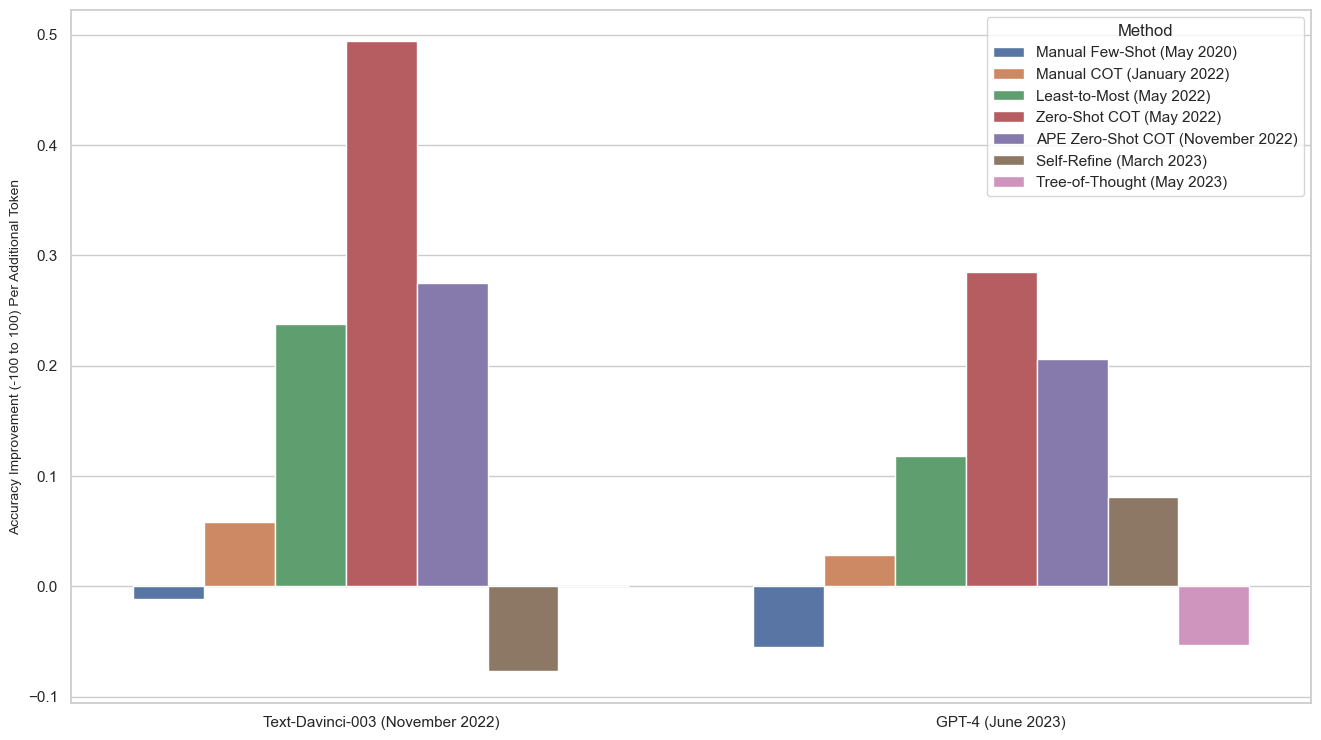

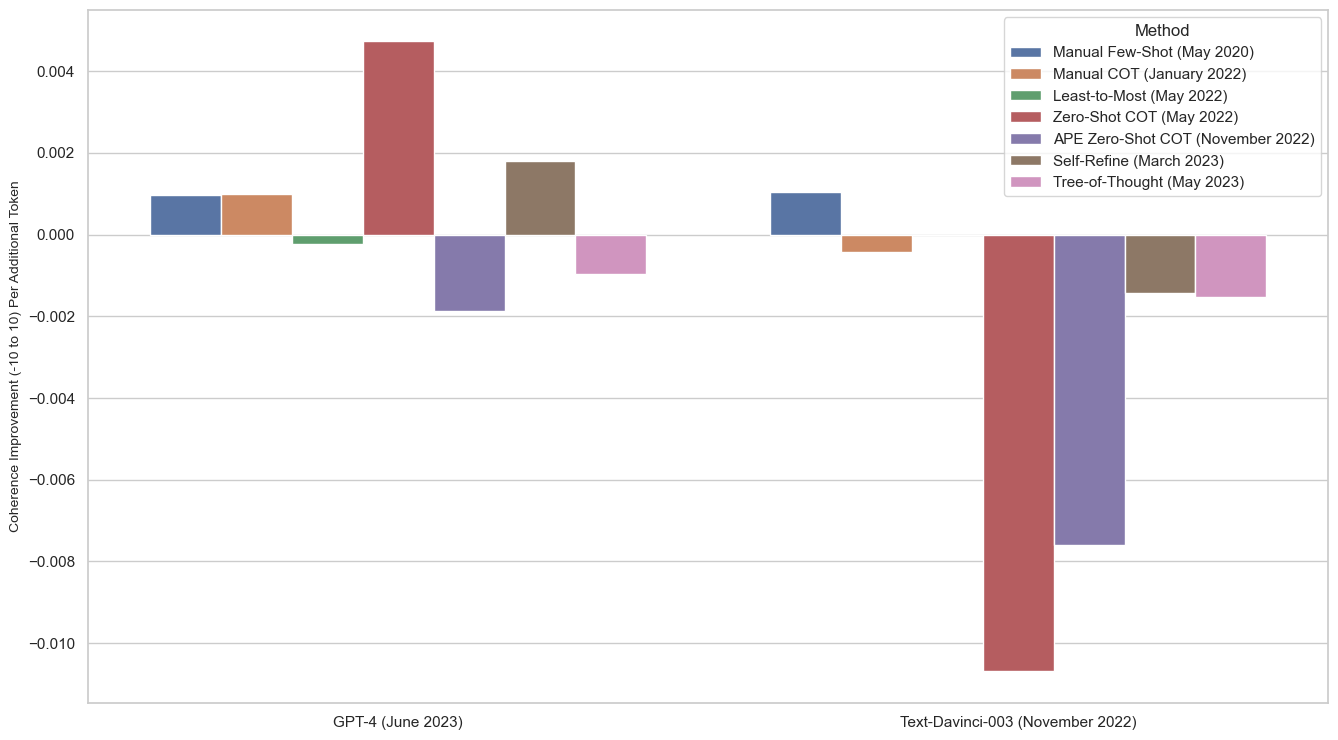

In [705]:
# Version sorted by ss_publication_date
# Merge on hand_labeled_data
# Add ss_publication_date to averages_for_changes
#print(averages_for_changes)
flattened_cols = [''.join(col).strip().replace('mean', '') for col in averages_for_changes.columns.values]
averages_for_changes.columns = flattened_cols
averages_for_changes_with_date = averages_for_changes.merge(hand_labeled_data, left_on='method', right_on='technique_name', how='left')
# Sort by ss_publication_date
averages_for_changes_with_date = averages_for_changes_with_date.sort_values('ss_publication_date')
print(averages_for_changes_with_date)

# Add Month and Year from the ss_publication_date column to the end of the Method column
averages_for_changes_with_date['Method'] = averages_for_changes_with_date['Method'] + ' (' + pd.to_datetime(averages_for_changes_with_date['ss_publication_date']).dt.strftime('%B %Y') + ')'

# Add Month and Year to the end of the Model column
# If Model = 'GPT-4', '(June 2023)'
# If Model = 'Text-Davinci-003', '(November 2022)'
averages_for_changes_with_date['Model'] = averages_for_changes_with_date['Model'] + ' ' + averages_for_changes_with_date['Model'].apply(lambda x: '(June 2023)' if x == 'GPT-4' else '(November 2022)')

#order_list = averages_for_changes_with_date[['Model', 'method']]
hue_order = list(averages_for_changes_with_date[['Method', 'ss_publication_date']].drop_duplicates().sort_values('ss_publication_date')['Method'])
print(hue_order)

# Create averages_for_changes_with_date_gsm8k and averages_for_changes_with_date_cw
averages_for_changes_with_date_gsm8k = averages_for_changes_with_date[averages_for_changes_with_date['task'] == 'gsm8k']
averages_for_changes_with_date_gsm8k['Percentage Points Accuracy Improvement Per Additional Token'] = averages_for_changes_with_date_gsm8k['change_in_accuracy_quality_per_change_in_conversation_length'] * 100
averages_for_changes_with_date_cw = averages_for_changes_with_date[averages_for_changes_with_date['task'] == 'cw']
averages_for_changes_with_date_cw['Coherence Improvement (-10 to 10) Per Additional 1,000 Tokens'] = averages_for_changes_with_date_cw['change_in_accuracy_quality_per_change_in_conversation_length'] * 1000

#print(averages_for_changes_with_date)

# Plot change in accuracy_quality per change in conversation_length
# Bar chart by model, method, task
# GSM8k plot
plt.figure(figsize=(16, 9))
#sns.barplot(x='Model', y='Percentage Points Accuracy Improvement Per Additional Token', hue='Method', data=averages_for_changes_gsm8k)
sns.barplot(x='Model', y='Percentage Points Accuracy Improvement Per Additional Token', hue='Method', hue_order=hue_order, data=averages_for_changes_with_date_gsm8k)#, order=order_list)
#plt.xlabel('Model')
#plt.xlabel('')
#plt.ylabel('Change in GSM8K Accuracy per Change in Conversation Length')
# No x axis title
plt.gca().set_xlabel('')
# Reduce y axis title font size
plt.gca().set_ylabel('Accuracy Improvement (-100 to 100) Per Additional Token', fontsize=10)
#plt.title('Change in GSM8K Accuracy per Change in Conversation Length by Model and Method')
plt.savefig('../Output/gsm8k_change_in_accuracy_quality_per_change_in_conversation_length_sorted_by_technique_age.png')
plt.show()

# Creative writing plot
plt.figure(figsize=(16, 9))
sns.barplot(x='Model', y='change_in_accuracy_quality_per_change_in_conversation_length', hue='Method', hue_order=hue_order, data=averages_for_changes_with_date_cw)
#sns.barplot(x='Model', y='change_in_accuracy_quality_per_change_in_conversation_length', hue='Method', data=averages_for_changes_cw)
#plt.xlabel('')
# plt.ylabel('Change in Creative Writing Coherence per Change in Conversation Length')
#plt.title('Change in Creative Writing Coherence per Change in Conversation Length by Model and Method')
# No x axis title
plt.gca().set_xlabel('')
plt.gca().set_ylabel('Coherence Improvement (-10 to 10) Per Additional Token', fontsize=10)
plt.savefig('../Output/cw_change_in_accuracy_quality_per_change_in_conversation_length_sorted_by_technique_age.png')
plt.show()


In [ ]:
# Also create a table with the change in accuracy_quality per change in conversation_length

# Unstack
# Pivot table - column method should go wide
change_per_table_pivot = averages_for_changes[['model', 'task', 'method', 'change_in_accuracy_quality_per_change_in_conversation_length']].set_index(['model', 'task', 'method']).unstack()
#pivot_table(index=['model', 'task'], columns='method', values='accuracy_quality').reset_index()

print(change_per_table_pivot)

# Fix axis
change_per_table_pivot = change_per_table_pivot.rename_axis([None, None, None], axis=1).reset_index()

# Sort rows by task - gsm8k task first, then cw
# Sort by model - text-davinci-003 first, then gpt4
change_per_table_pivot = change_per_table_pivot.sort_values(by=['task', 'model'], ascending=[True, True]).reset_index().drop(columns=['index'])

#print(avg_accuracy_quality_pivot.columns)

flattened_cols = [''.join(col).strip().replace('change_in_accuracy_quality_per_change_in_conversation_length', '') for col in change_per_table_pivot.columns.values]
change_per_table_pivot.columns = flattened_cols

#print(avg_accuracy_quality_pivot)

# Sort and output table

# Sort rows by task - gsm8k task first, then cw
# Sort by model - text-davinci-003 first, then gpt4
#change_per_table = change_per_table.sort_values(by=['task', 'model'], ascending=[True, True])

# Order columns: direct_prompting, zero_shot_cot, ape_zero_shot_cot, tree_of_thought, self_refine, least_to_most, manual_few_shot, manual_cot
change_per_table = change_per_table_pivot[['model', 'task', 'zero_shot_cot', 'ape_zero_shot_cot', 'tree_of_thought', 'self_refine', 'least_to_most', 'manual_few_shot', 'manual_cot']]

# Output to LaTeX
change_per_table.to_latex('../Output/change_per_table.tex', index=False)


            change_in_accuracy_quality_per_change_in_conversation_length  \
                                                                           
method                                                 ape_zero_shot_cot   
model task                                                                 
gpt4  cw                                             -0.001874             
      gsm8k                                           0.002057             
td3   cw                                             -0.007606             
      gsm8k                                           0.002746             

                                                                  \
                                                                   
method      least_to_most manual_cot manual_few_shot self_refine   
model task                                                         
gpt4  cw        -0.000225   0.000982        0.000967    0.001806   
      gsm8k      0.001185   0.000284       -0.00055

C:\Users\ijyli\AppData\Local\Temp\ipykernel_23760\2597549976.py:15: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  change_per_table_pivot = change_per_table_pivot.sort_values(by=['task', 'model'], ascending=[True, True]).reset_index().drop(columns=['index'])


## Complexity

Run generic function for number of reasoning steps, sentence length, FRE

Bar charts of differences

Generic function for assessment of ease of review too

In [ ]:
means_table('num_linebreaks')
means_table('num_sentences')
means_table('num_step_i')
means_table('num_1_dot_etc')
means_table('sentence_length')
means_table('fres')


  model   task  ape_zero_shot_cot  direct_prompting  least_to_most  \
0  gpt4     cw               0.00              0.00           0.00   
2   td3     cw               4.37              0.98           7.03   
1  gpt4  gsm8k               0.00              0.00           0.00   
3   td3  gsm8k               4.44              0.16           4.16   

   manual_cot  manual_few_shot  self_refine  tree_of_thought  zero_shot_cot  
0        0.00             0.00         1.56             4.00           0.00  
2        6.01             1.07         3.10            11.29           4.67  
1        0.00             0.00         2.20             5.11           0.00  
3        0.00             0.00         1.16             1.39           3.25  
  model   task  ape_zero_shot_cot  direct_prompting  least_to_most  \
0  gpt4     cw              15.43             11.32          14.76   
2   td3     cw              10.12              7.60          17.82   
1  gpt4  gsm8k               3.15              1.

In [ ]:
# Differences of scores 
# Responses versus prompts
# Responses versus provided answer for GSM8k

# Variables: 
# 'num_linebreaks_prompts': num_linebreaks_prompts,
# 'num_sentences_prompts': num_sentences_prompts,
# 'num_step_i_prompts': num_step_i_prompts,
# 'num_1_dot_etc_prompts': num_1_dot_etc_prompts,
# 'sentence_length_prompts': sentence_length_prompts,
# 'fres_prompts': fres_prompts,
# 'num_linebreaks_provided': num_linebreaks_provided,
# 'num_sentences_provided': num_sentences_provided,
# 'num_step_i_provided': num_step_i_provided,
# 'num_1_dot_etc_provided': num_1_dot_etc_provided
# Loop over variables and create differences variables
comparison_vars = ['num_linebreaks_prompts', 'num_sentences_prompts', 'num_step_i_prompts', 'num_1_dot_etc_prompts', 'sentence_length_prompts', 'fres_prompts', 'num_linebreaks_provided', 'num_sentences_provided', 'num_step_i_provided', 'num_1_dot_etc_provided']
for var in comparison_vars:
    # Create a variable that is the difference between the prompts and responses
    # var + '_diff'
    combined_data[var + '_diff'] = combined_data[var] - combined_data[var.replace('_prompts', '').replace('_provided', '')]

# Aggregate "_diff" variables by model, task, method
differences = combined_data[['model', 'task', 'method', 'num_linebreaks_prompts_diff', 'num_sentences_prompts_diff', 'num_step_i_prompts_diff', 'num_1_dot_etc_prompts_diff', 'sentence_length_prompts_diff', 'fres_prompts_diff', 'num_linebreaks_provided_diff', 'num_sentences_provided_diff', 'num_step_i_provided_diff', 'num_1_dot_etc_provided_diff']].groupby(['model', 'task', 'method']).agg(['mean']).reset_index()


In [ ]:
# Fix axis
#differences_noax = differences.rename_axis([None, None], axis=1).reset_index()

# Sort rows by task - gsm8k task first, then cw
# Sort by model - text-davinci-003 first, then gpt4
#change_per_table_pivot = change_per_table_pivot.sort_values(by=['task', 'model'], ascending=[True, True]).reset_index().drop(columns=['index'])

#print(avg_accuracy_quality_pivot.columns)

flattened_cols = [''.join(col).strip().replace('mean', '') for col in differences.columns.values]
#change_per_table_pivot.columns = flattened_cols
differences.columns = flattened_cols

#differences_noax
differences


,model,task,method,num_linebreaks_prompts_diff,num_sentences_prompts_diff,num_step_i_prompts_diff,num_1_dot_etc_prompts_diff,sentence_length_prompts_diff,fres_prompts_diff,num_linebreaks_provided_diff,num_sentences_provided_diff,num_step_i_provided_diff,num_1_dot_etc_provided_diff
0,gpt4,cw,ape_zero_shot_cot,0.00,-9.45,-0.90,-0.81,-9.978841,14.9564,NaN,NaN,NaN,NaN
1,gpt4,cw,direct_prompting,0.00,-6.33,0.00,2.00,-10.032668,15.4201,NaN,NaN,NaN,NaN
2,gpt4,cw,least_to_most,0.00,22.23,0.00,9.51,-2.662473,6.8655,NaN,NaN,NaN,NaN
3,gpt4,cw,manual_cot,0.00,23.06,0.00,11.06,-3.258196,5.5555,NaN,NaN,NaN,NaN
4,gpt4,cw,manual_few_shot,0.00,17.74,0.00,6.00,-4.185974,7.2873,NaN,NaN,NaN,NaN
5,gpt4,cw,self_refine,0.00,-9.70,0.00,2.48,1.431063,8.6439,NaN,NaN,NaN,NaN
6,gpt4,cw,tree_of_thought,0.00,-27.43,0.00,-1.93,-4.116316,15.8285,NaN,NaN,NaN,NaN
7,gpt4,cw,zero_shot_cot,0.00,-9.94,-0.66,-1.58,-10.439468,17.6945,NaN,NaN,NaN,NaN
8,gpt4,gsm8k,ape_zero_shot_cot,0.00,0.21,-0.39,-1.57,NaN,NaN,3.42,-0.47,-0.39,-0.67
9,gpt4,gsm8k,direct_prompting,0.00,1.85,0.00,-0.90,NaN,NaN,3.42,1.17,0.00,0.00


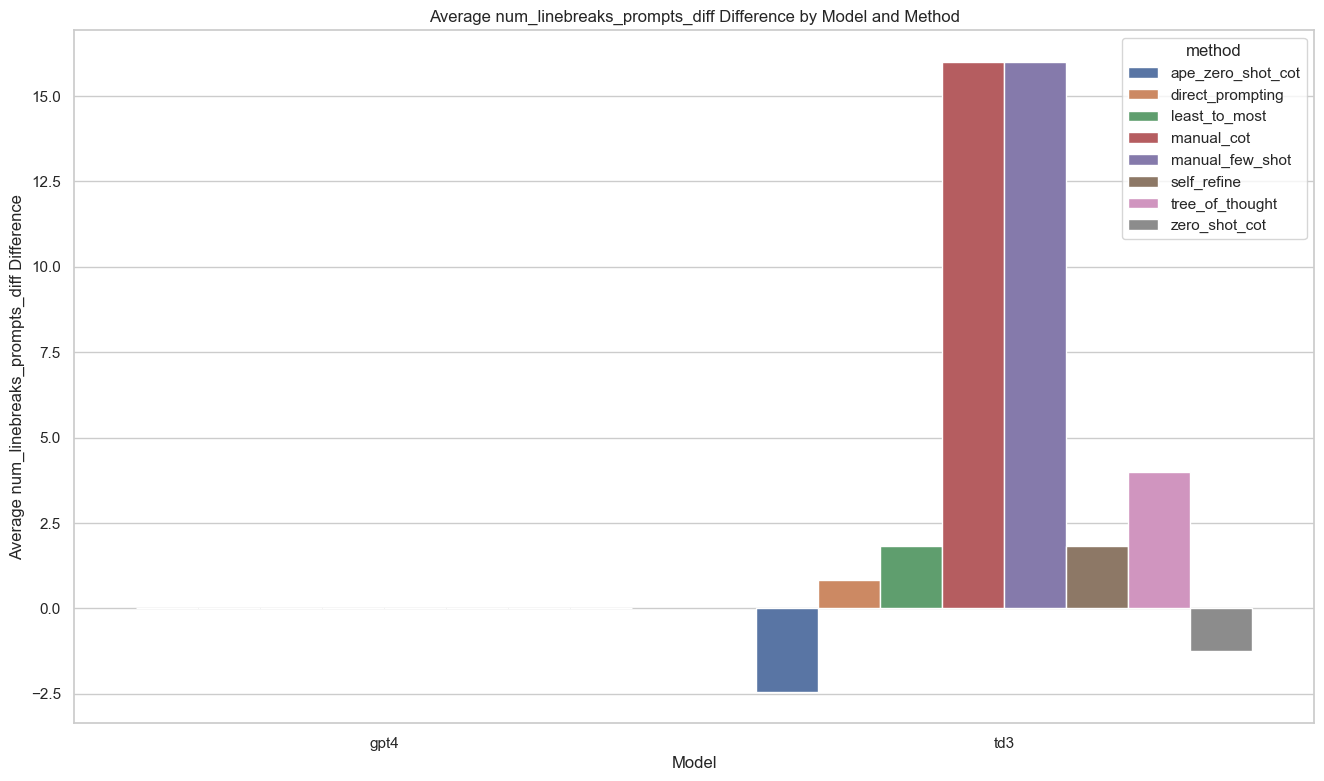

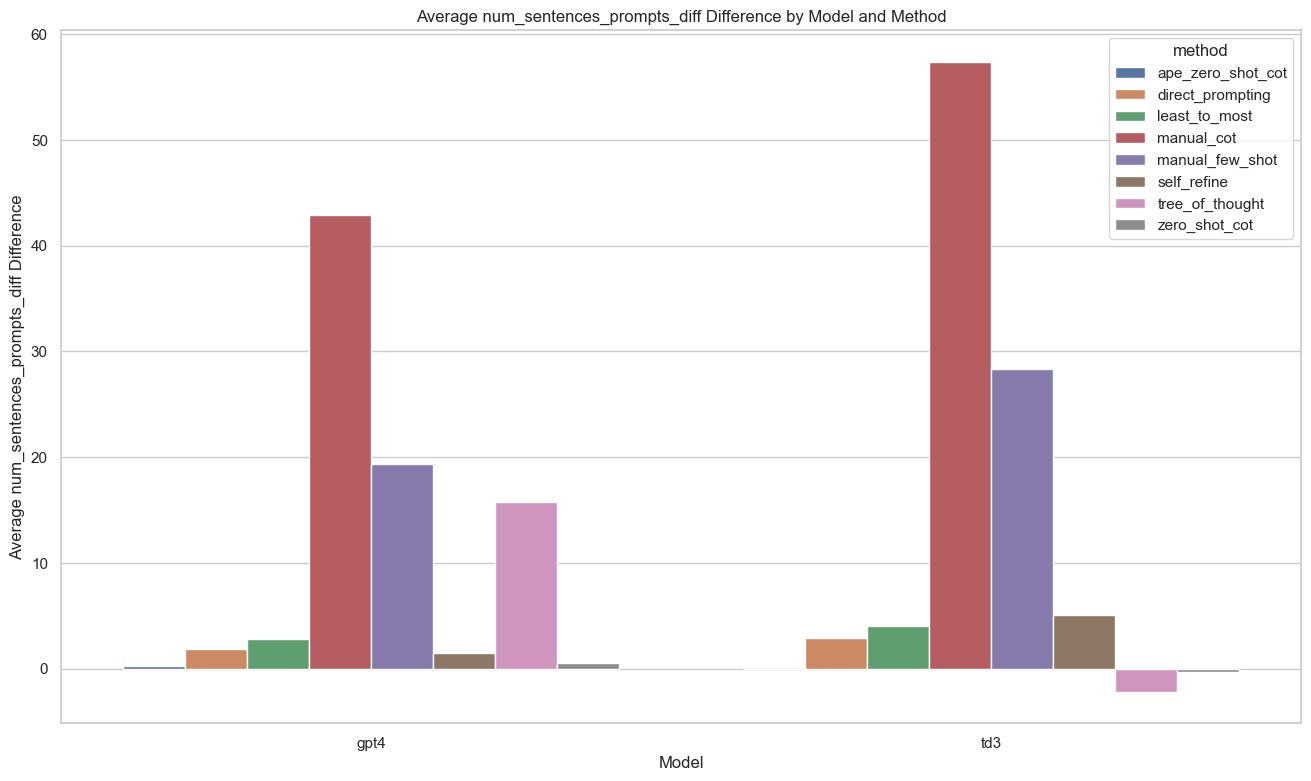

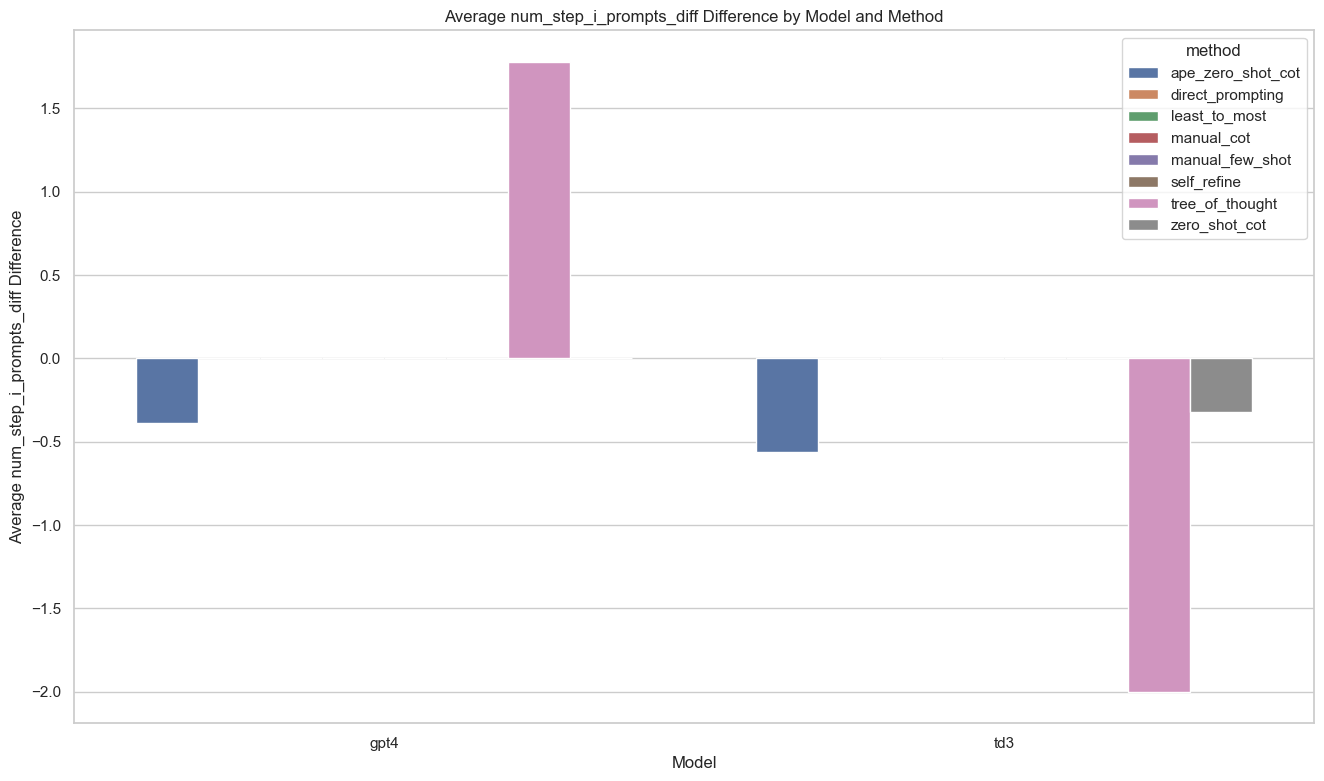

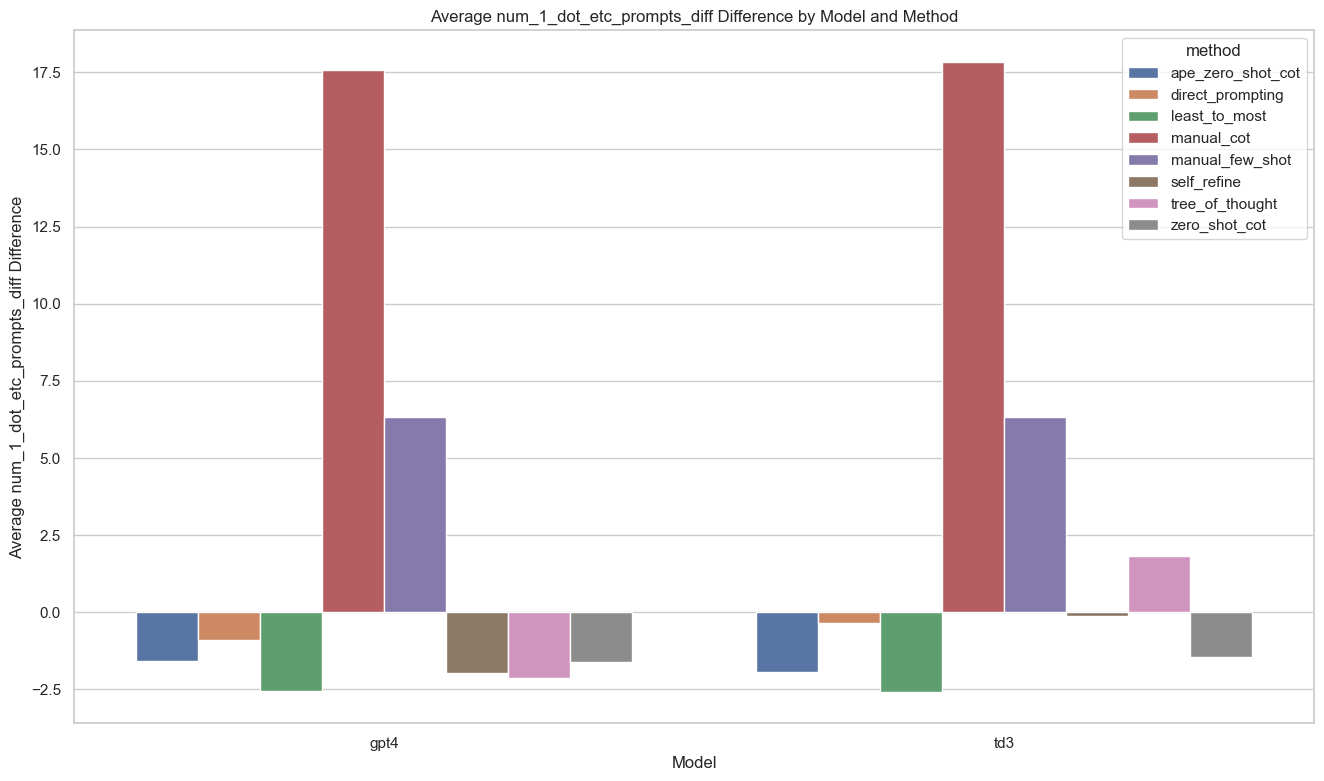

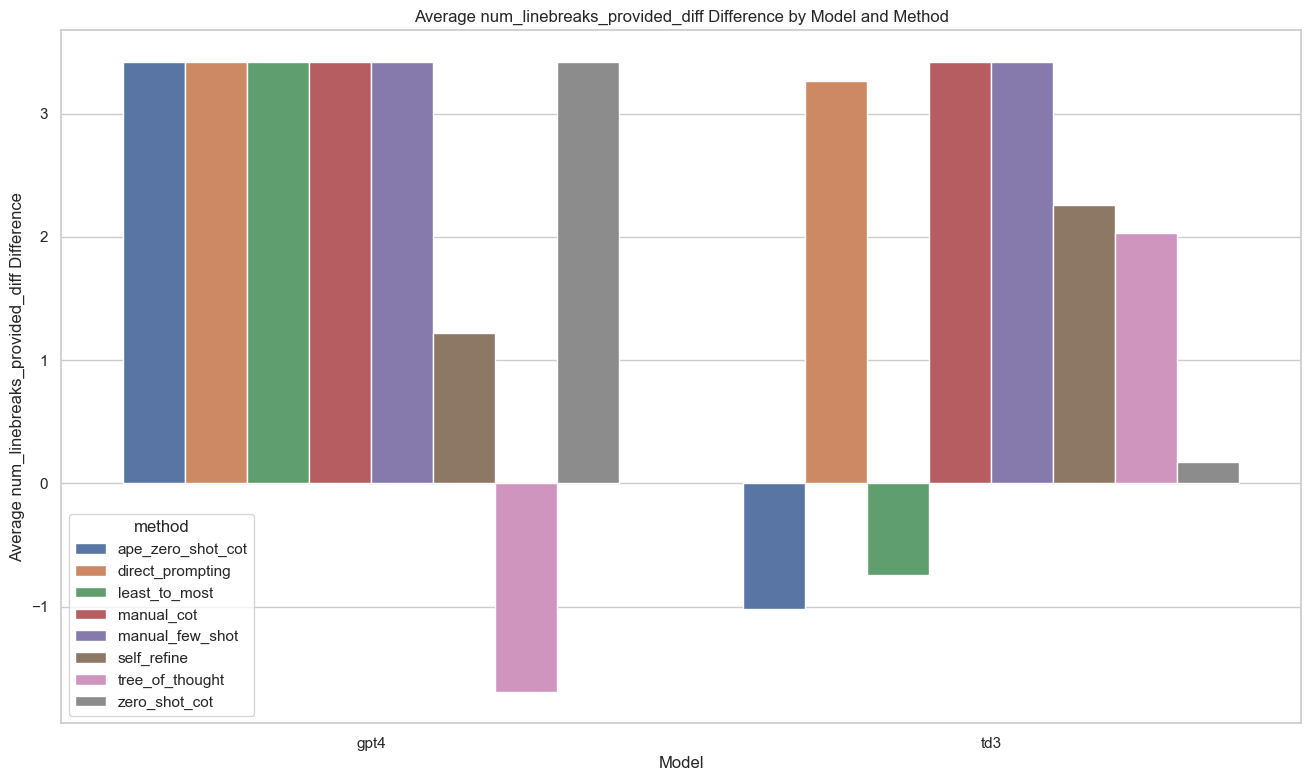

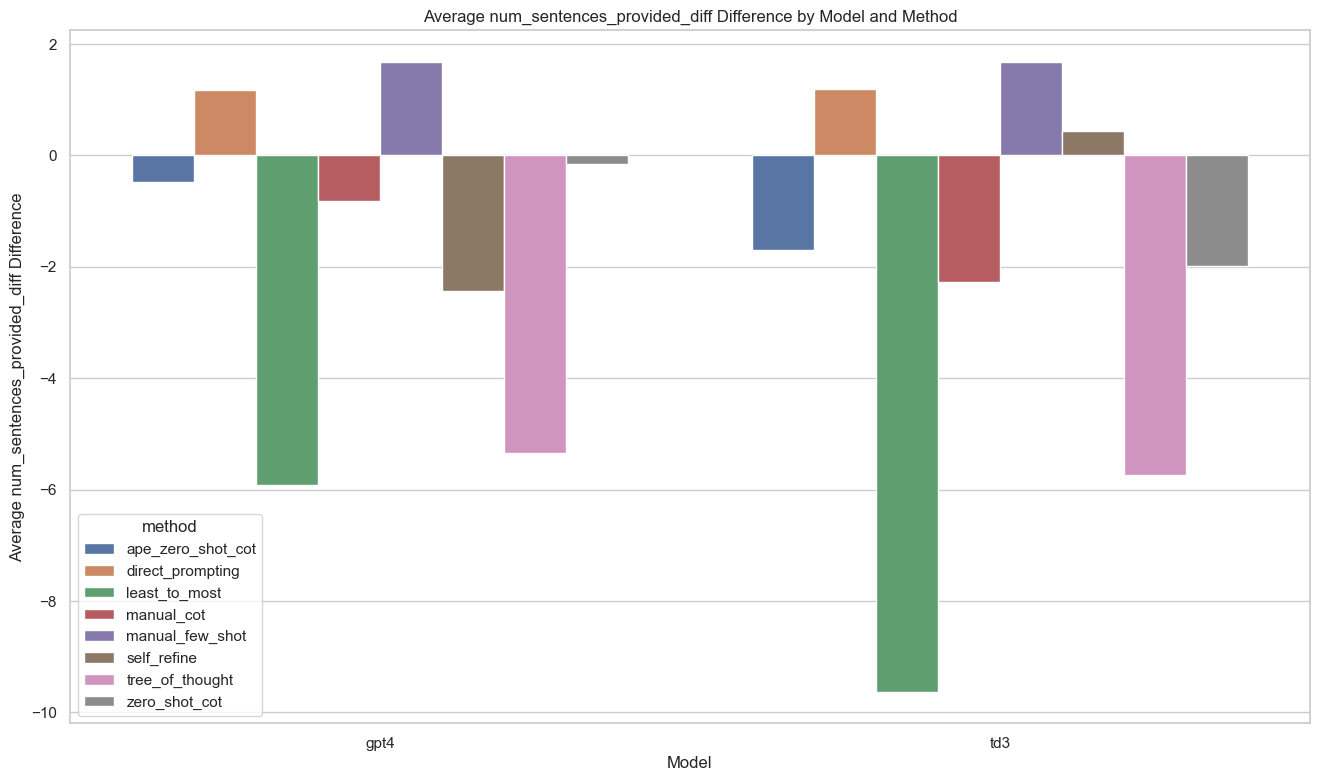

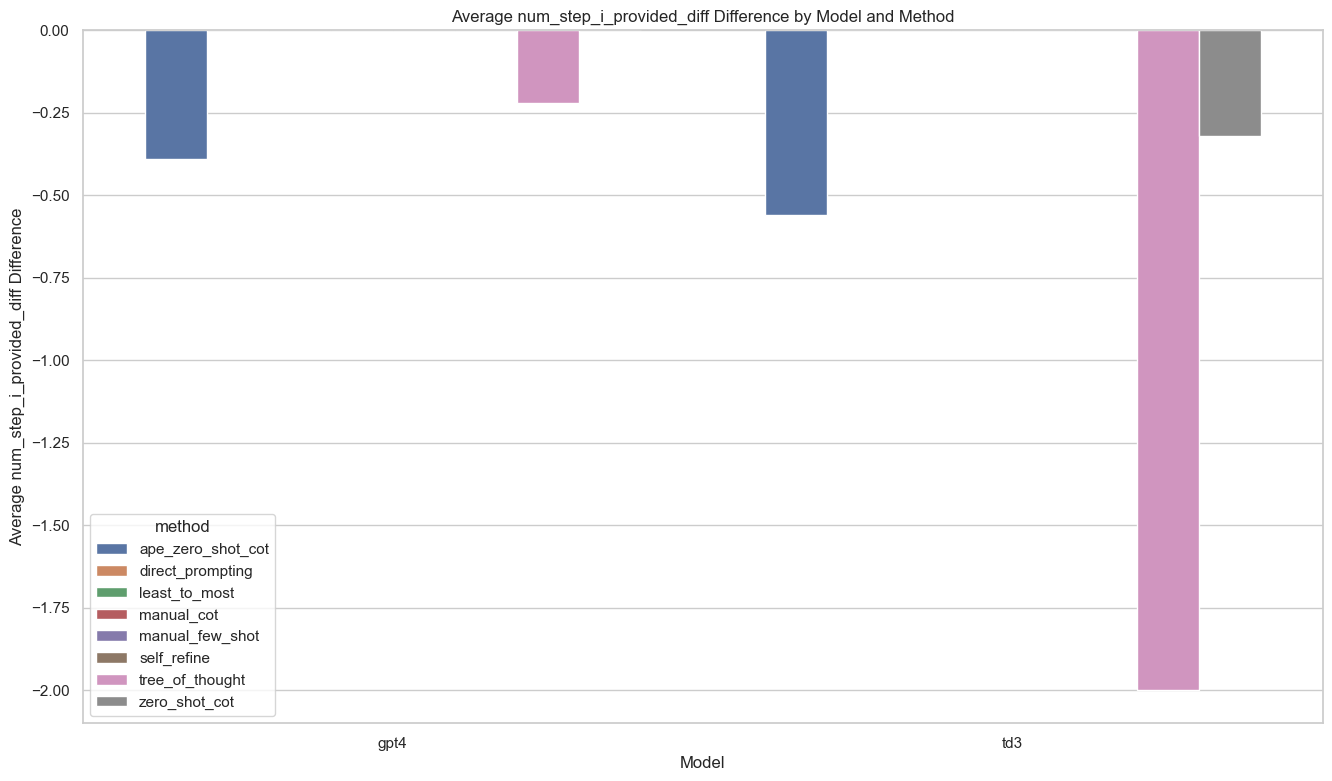

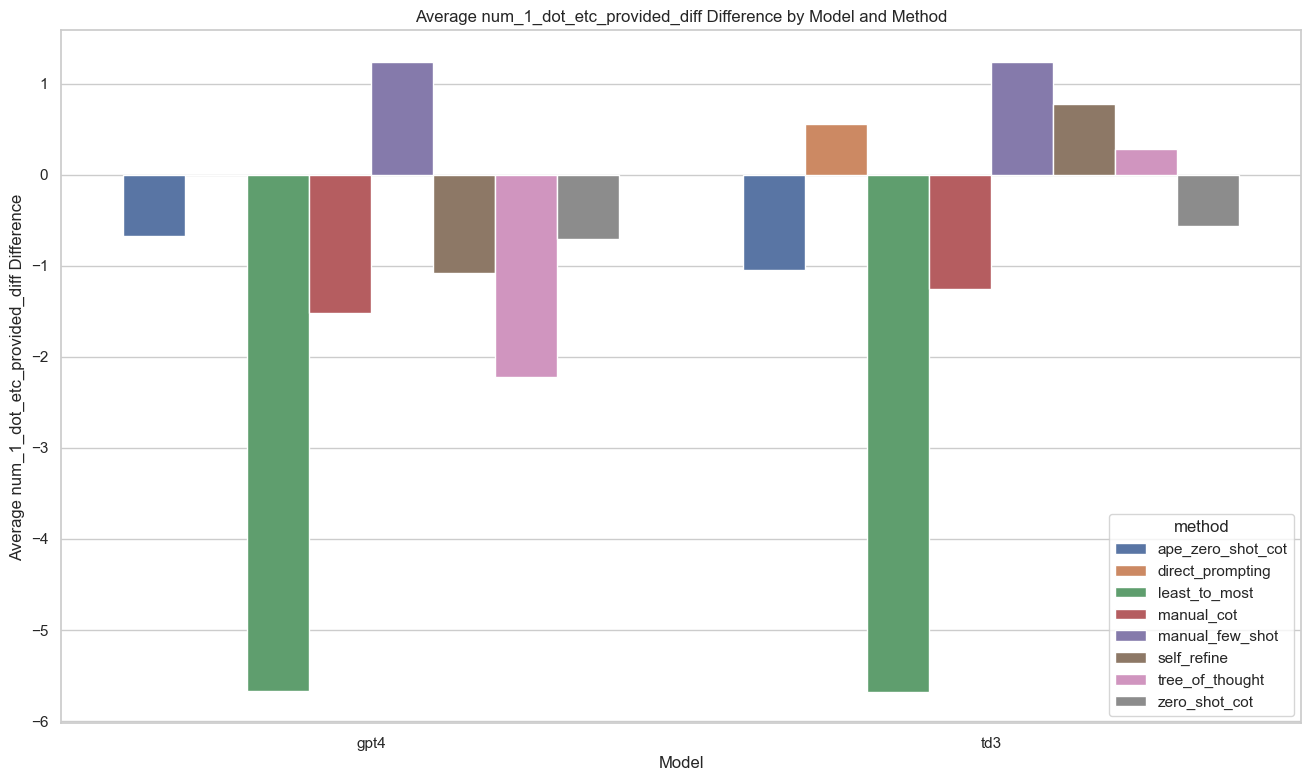

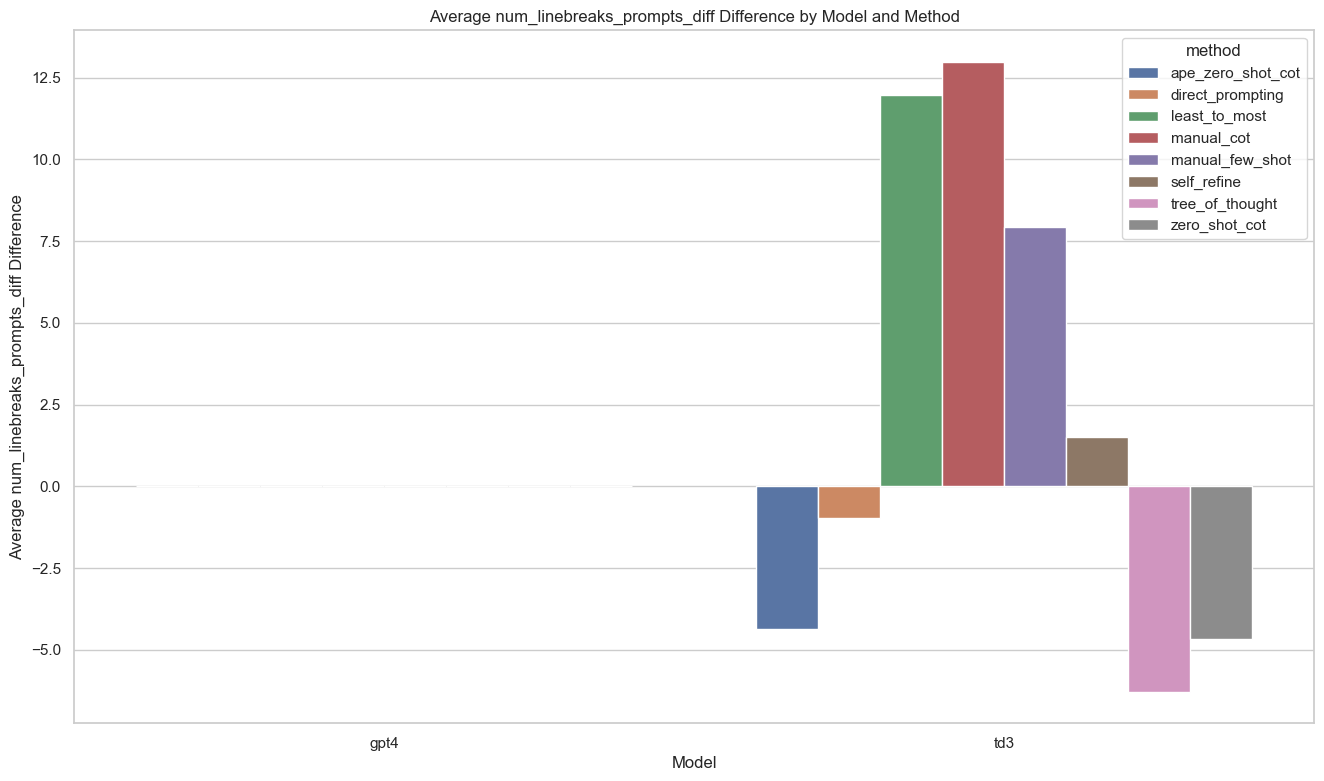

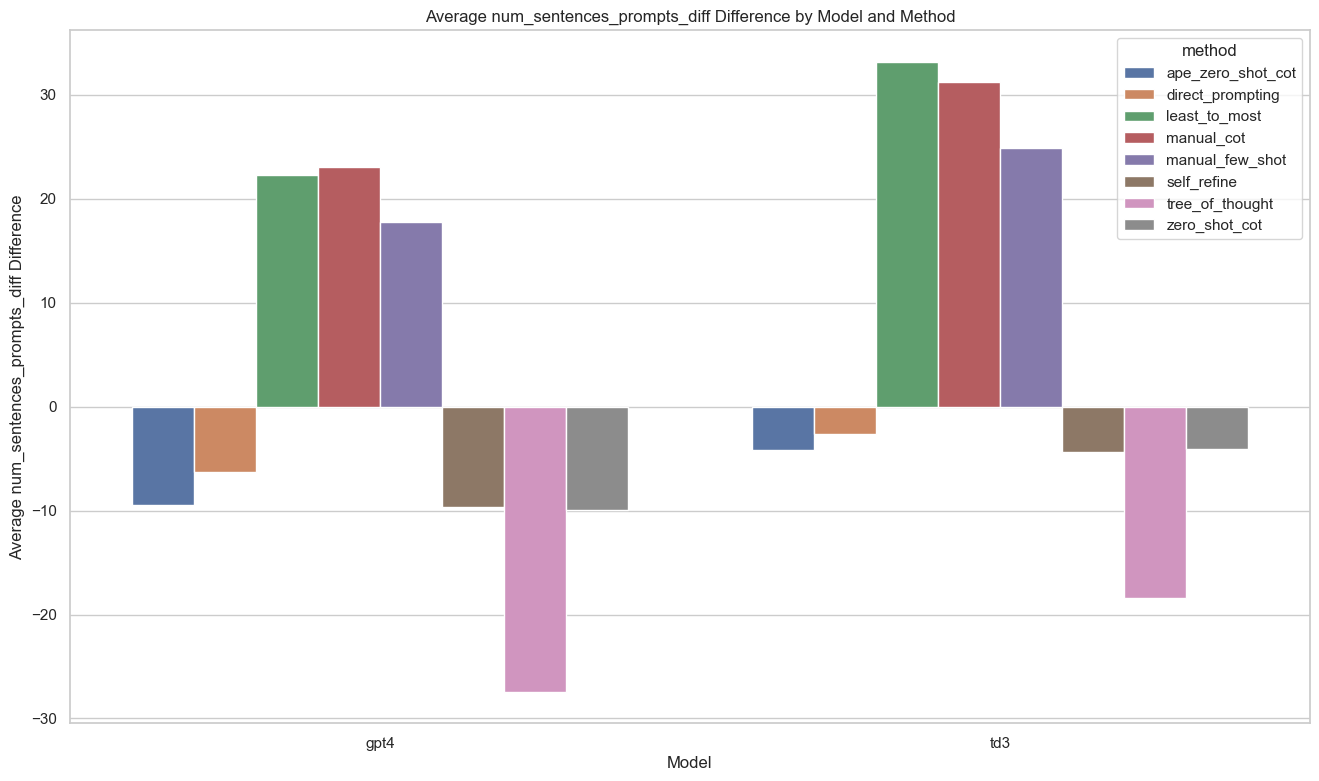

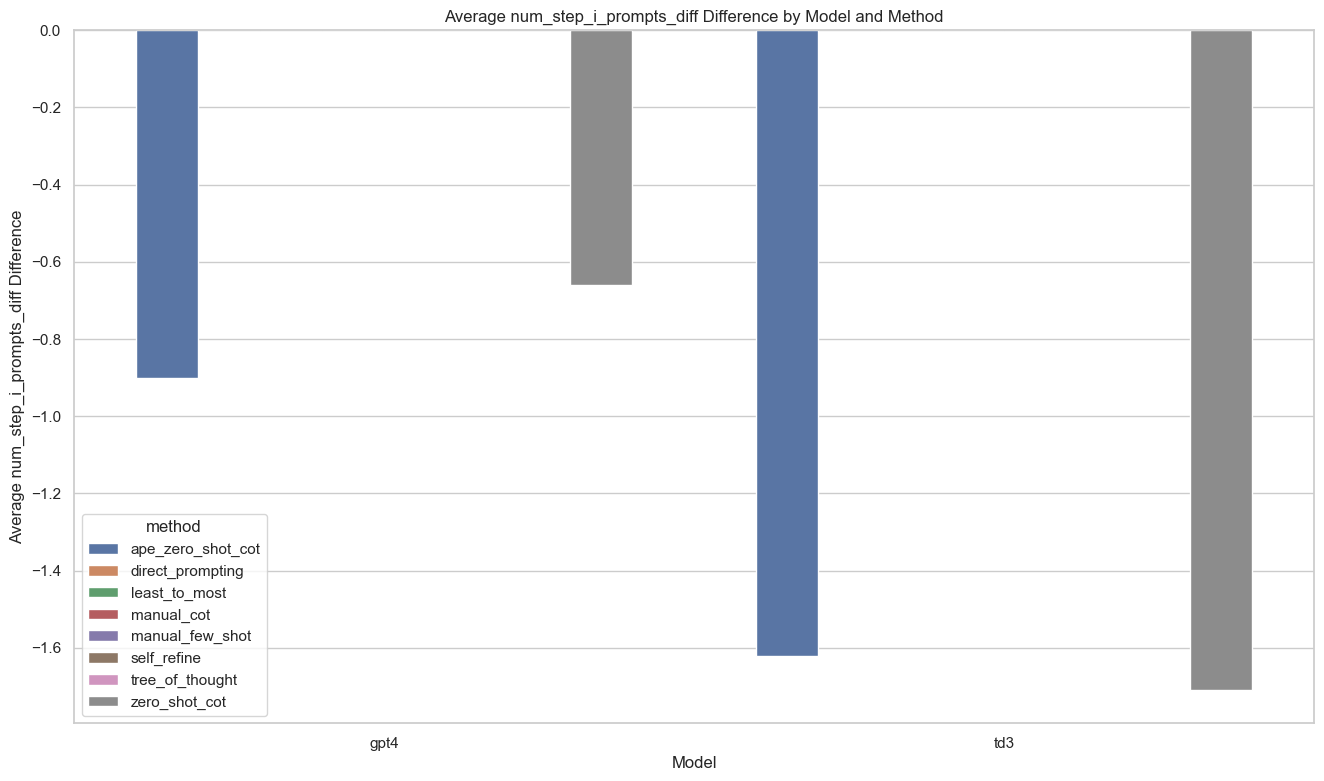

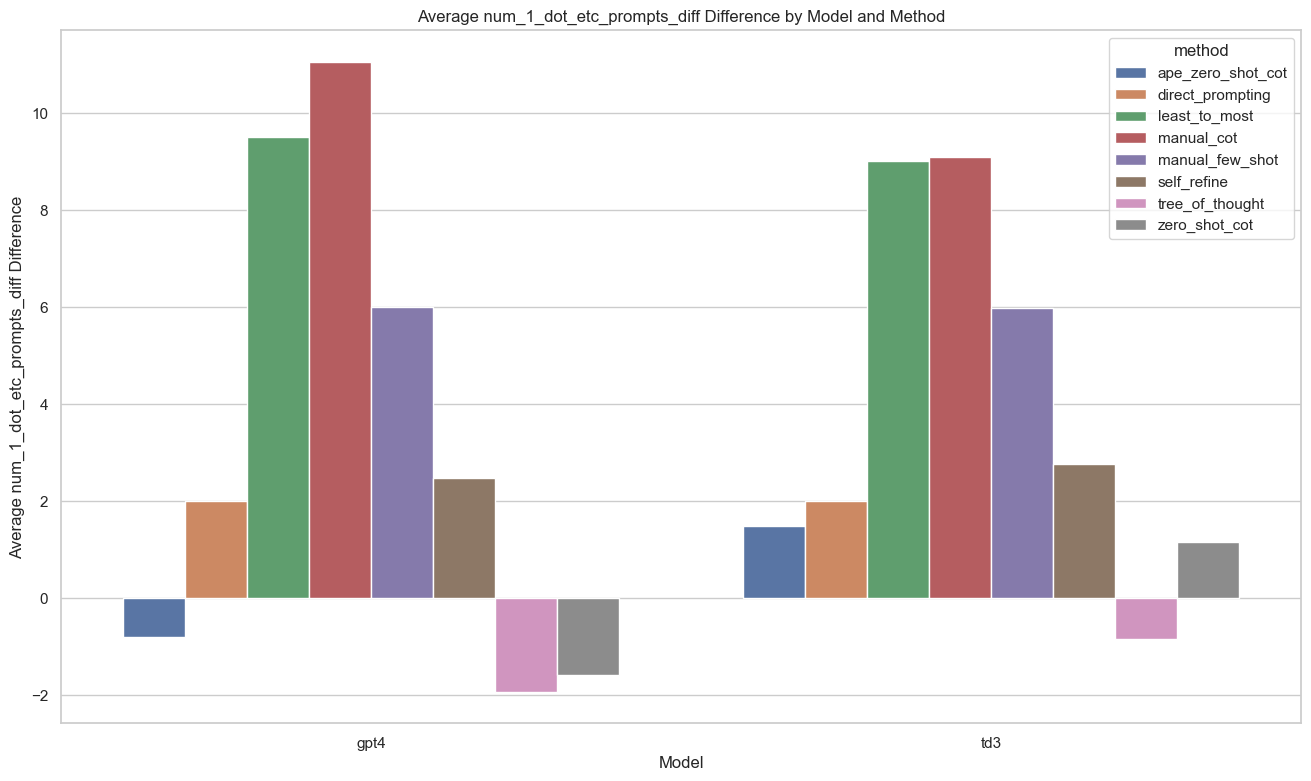

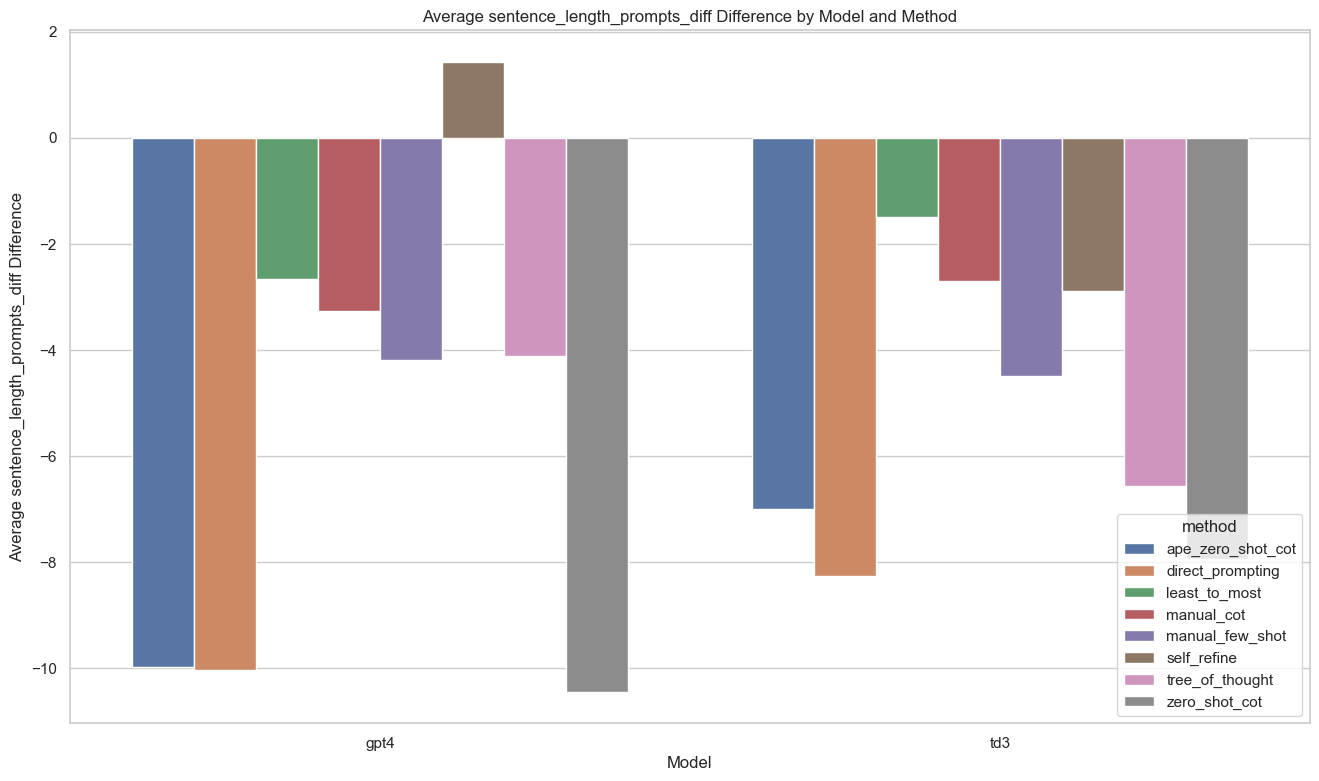

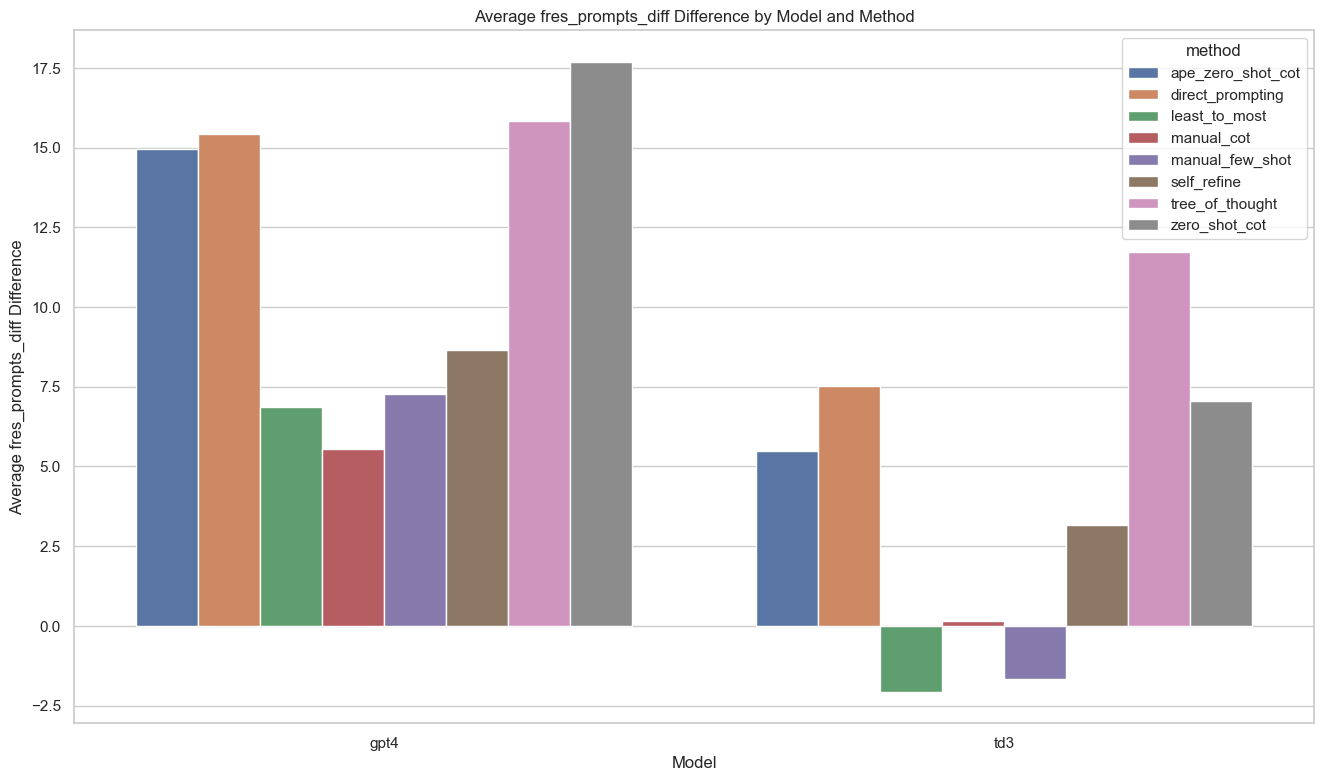

In [ ]:
# Create plots of _diff variables by model, task, method

# GSM8k plots
# Loop over variables
comparison_vars_gsm8k = ['num_linebreaks_prompts_diff', 'num_sentences_prompts_diff', 'num_step_i_prompts_diff', 'num_1_dot_etc_prompts_diff', 'num_linebreaks_provided_diff', 'num_sentences_provided_diff', 'num_step_i_provided_diff', 'num_1_dot_etc_provided_diff']
for var in comparison_vars_gsm8k:
    # Plot
    plt.figure(figsize=(16, 9))
    sns.barplot(x='model', y=var, hue='method', data=differences[differences['task'] == 'gsm8k'])
    plt.xlabel('Model')
    plt.ylabel('Average ' + var + ' Difference')
    plt.title('Average ' + var + ' Difference by Model and Method')
    plt.savefig('../Output/gsm8k_' + var + '.png')
    plt.show()

# Creative writing plots
# Loop over variables
comparison_vars_cw = ['num_linebreaks_prompts_diff', 'num_sentences_prompts_diff', 'num_step_i_prompts_diff', 'num_1_dot_etc_prompts_diff', 'sentence_length_prompts_diff', 'fres_prompts_diff']
for var in comparison_vars_cw:
    # Plot
    plt.figure(figsize=(16, 9))
    sns.barplot(x='model', y=var, hue='method', data=differences[differences['task'] == 'cw'])
    plt.xlabel('Model')
    plt.ylabel('Average ' + var + ' Difference')
    plt.title('Average ' + var + ' Difference by Model and Method')
    plt.savefig('../Output/cw_' + var + '.png')
    plt.show()


In [ ]:
means_table('ease_of_review_1_easy_10_hard')


  model   task  ape_zero_shot_cot  direct_prompting  least_to_most  \
0  gpt4     cw                8.2               1.6            7.3   
2   td3     cw                3.5               NaN            3.0   
1  gpt4  gsm8k                NaN               NaN            NaN   
3   td3  gsm8k                NaN               2.9            NaN   

   manual_cot  manual_few_shot  self_refine  tree_of_thought  zero_shot_cot  
0         3.2              4.4          4.5              4.2            8.2  
2         2.3              2.1          4.1              8.5            3.8  
1         NaN              NaN          NaN              NaN            NaN  
3         NaN              NaN          NaN              NaN            NaN  
